# Project 1: Deep Neural Network for Jet Classification in High Energy Physics
## MTH 5320
## Stephen D. Butalla
### 2020/10/09

## Introduction
An emphasis of work done at the Large Hadron Collider is the discovery of new physics. One of the many Beyond Standard Model (BSM) theories proposes a new $SU(2)$ gauge group extension to the SM, which makes the total product group
$$SU(3)\times SU(2)\times U(1)\times SU(2)'.$$
This new $SU(2)'$ group generates, (in much the same manner as the $W^{\pm}$ and $Z^{0}$ gauge bosons are generated by the $SU(2)$ group), new "primed" vector bosons: the $W^{\pm'}$ and the $Z'$. Event classification is an important part of each of these process, as we need to sift through mountains of data to find the unique signatures of new physics. As such, machine learning could help optimize this search by classifying images reconstructed from the calorimeters$^{1}$ of the detector systems at a particle accelerator.

<br />

When searching for any new physics, it is customary to first simulate events using Monte Carlo production to see if it is possible to complete a search using real data, and then finally look for signatures of new physics. This project seeks to use a deep neural network to classify simulated jet images of the BSM process
\begin{equation}
q+q'\rightarrow W'\rightarrow W + Z\rightarrow q+q' + \nu+\bar{\nu}.
\end{equation}
The Feynman diagram of this process is displayed below:
<br />
![Wprime](Wprime.png)

<br />

An important signature of this process which would indicate new physics is the formation of jets, which are a highly collimated beam of particles generated from subsequent reactions. In the case of the process above, the jet would have the distinct signature of two main prongs which are generated from the two quarks q and q′ in the final state (the $Z^{0}$ boson decays to a neutrino/antineutrino pair, which will not cause any signal in the detector system). For a diagram of a similar process, see the figure below. Note that the jet formation process here is slightly different, since the diagram displays two W bosons in the case of the boosted $W$ decays. With the process described by this project, we have a $Z$ and a $W$ decay product from the $W'$ (a slight difference), although the schematic representation of jet formation is identical in the quark/gluon case.

<br />

![JetDiagram](JetDiagram.png)
Figure obtained from [here](https://arxiv.org/abs/1011.2268).

<br />

Thus, one can make a search for these distinct two-pronged jets. However, there are quantum chromodynamic (QCD) background jets to contend with, as they are produced in any hard scattering processes. The goal, therefore, would be to create a neural network to distinguish QCD background jets from the signals of interest, i.e., the W′ initiated jets.

<br />

$^{1}$A calorimeter is simply a detector that measures the energy deposited by a particle.

### The Dataset
#### Data Generation
The dataset was created by B. Nachman, L. de Oliveira, and M. Paganini, and was obtained [here](https://data.mendeley.com/datasets/4r4v785rgx/1). This dataset was generated by [`Pythia v.8.170`](http://home.thep.lu.se/~torbjorn/pythia81html/Welcome.html), at a center of mass (CM) energy of $\sqrt{s}=E_{CM}=14$ TeV (the same center of mass energy the LHC runs at). The physical process $q+q'\rightarrow W'\rightarrow W + Z\rightarrow q+q' + \nu+\bar{\nu}$ is generated via a Monte-Carlo simulation which produces a $W'$, decaying to a Lorentz boosted $W$ boson, which further decays to a quark/antiquark pair (the $Z^{0}$ boson decays quietly to a $\nu/\bar{\nu}$ pair, so no signal is generated from this part of the process).

<br />

During event$^{1}$ generation, jets are tagged using the anti-$k_{t}$ algorithm in [`FastJet v. 3.0.3`](http://fastjet.fr/). Because of kinematic considerations, the algorithm restricts jet tagging to the bounds given by the $W$ boson's transverse momentum, $250 < $p_{T}$ < 300$ GeV (note that momentum is really in units of GeV/c; since particle physicists are lazy, we like to use "natural units" where $\hbar=c=1$).

<br />

Three variables of interest are computed during the jet-tagging process, which include the jet mass, defined by the four-momentum contraction $p_{\mu}p^{\mu}$ is computed by
$$m_{\textrm{jet}}^{2}=\sum_{i,j}p_{i}p_{j},$$
the $n$-subjettiness, a measure of the internal structure of the jets, (for more information, see the article [here](https://arxiv.org/abs/1011.2268) by J. Thaler and K. Van Tilburg) is given by
$$\tau_{N}=\dfrac{1}{d_{0}}\sum_{k}p_{T,k}\textrm{min}\big\{\Delta R_{1,k},\Delta R_{2,k},\cdots, \Delta R_{N,k}\big\}$$
where $k$ is the k$^{\textrm{th}}$ particle in the jet, $p_{T,k}$ is the transverse momentum of particle $k$, $\Delta R_{k}$ is the distance between a subjet and particle $k$, and is defined by the square root of the quadrature sum of the coordinate difference in the pseudorapidity$^{2}$ ($\eta$) and azimuthal ($\phi$) coordinate, i.e.,
$$\Delta R = \sqrt{(\Delta \eta)^{2}+(\Delta \phi)^{2}}$$
Here, the 21-subjetiness ($\tau_{21}$) is calculated to distinguish jets with 1 "prong" from jets with 2 "prongs." Further jet trimming is then performed to reduce the contribution from pileup (multiple hard scattering events that can obfuscate the signal) and reduce additional background from the original event.

<br />

During these parton showers, most of the energy is absorbed within the calorimeter. During the event reconstruction portion The calorimeter is discretized, and the energy deposited in each pixel of the calorimeter is used to form "images" of the jets. Four steps are then employed to prepare these images for use in a neural network.

<br />

$^{1}$Events are a single moment in time that contain all kinematic and particle identification information (e.g., all momentum, energy, position, etc.; information about all muons, electrons, hadrons, etc.).

$^{2}$Pseudorapidity is a relativistic coordinate commonly used in particle physics and is defined by $\eta\equiv-\ln\big[\tan(\theta/2)\big]$, where $\theta$ is the angle between a particle's vector momentum and the beamline ($z$-axis).

<br />

#### Preprocessing
The four steps the authors used to preprocess the jet images are (1) translation, (2) rotation, (3) repixelization, and (4) inversion (see [here](https://arxiv.org/abs/1511.05190)). These preprocessing steps are performed to reduce the size of the image and also to improve performance of the network (since all images will be aligned using a common standard).

<br />

##### Step 1: Translation
The first step, translation, is performed to align all jet images so that the first subjet is at the center of the coordinate system [$(\eta = 0,\phi = 0)$]. 

<br />

##### Step 2: Rotation
The second step is rotation about $\phi$ axis ($\phi \in [0,2\pi]$). If the jet is a QCD background jet (single prong), the the jet is rotated such that the first principle component of pixel intentisty is aligned along the $y$-axis. If the jet is a boosted $W$ initiated jet, the image is rotated so that the second subjet is aligned directly beneath the first jet. 

<br />

##### Step 3: Repixelization
In the case that the rotation in $\phi$ is not
$$\phi' = \dfrac{n\pi}{4},$$
where $n = 0,1,2, \ldots$, the original and rotated grids will not align. In this situation, then, cubic spline interpolation is used to redistribute the energy values in the new grid system, thus "repixelizing" the image.

<br />

##### Step 4:  Parity Inversion
Finally, the image is parity inverted, so that the largest summed pixel intensities are on the right of the image. Since this translation in the $\eta$ coordinate provides a Lorentz boost (transformation) to the energy, (remember, $\eta$ is a relativistic coordinate), the energy intensities will not be preserved. So, instead of retaining the original energy values for the pixel intensities, the transverse energy, given by 
$$p_{T}=\dfrac{E}{\cosh(\eta)}$$
is used since this quantity is Lorentz invariant (transverse momentum is in the $x$-$y$ plane, while pseudorapidity is in the $z$-direction, and thus is not boosted by translation in $\eta$.

<br />

This dataset contains over $8.73\times10^{5}$ $25\times25$ simulated images, which cover an area of [-1.25,1.25] in both the $\eta$ and $\phi$ coordinates. The data have two labels: (0) QCD background jets and (1) Boosted W′ initiated jets. After discussing the strategy for hyperparameter tuning, I will perform some preliminary data exploration, construct the network, and then finally train, tune, and test.

<br />

### Strategy
Since there is a good amount of time to complete this project, we will scan the hyperparameter spaces of interest and then determine the optimal values of the parameters. The upper and lower bounds of the hyperparameter space will be taken from the fourth homework assignment, since it is reasonable to expect that this dataset (a set of $25\times25$ pixelized images) will perform similarly to the CIFAR-10 dataset ($32\times32\times3$). Although, in theory, this dataset should produce better results since the .At each step of the loop, the training and testing accuracies will be stored.


### Loading the Data and Exploring
Below, I import the data and perform some preliminary exploration/visualization of the contents of the file.

In [3]:
import h5py as h5 # For opening hdf5 files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Colormap for image visualization
import collections
import random
from time import time

In [4]:
dataset = h5.File('jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5', 'r') # Load file
print('Dataset Keys:\n', list(dataset.keys()))

Dataset Keys:
 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']


In [5]:
jetIm = dataset['image'] # Store all images
jetLabels = dataset['signal'] #Store all label data

print('Data type: {}'.format(type(jetIm)))
print('Data type: {}'.format(type(jetLabels)))
print('Dimensions of the data: {}'.format(jetIm.shape))
print('Dimensions of the labels: {}'.format(jetLabels.shape))

Data type: <class 'h5py._hl.dataset.Dataset'>
Data type: <class 'h5py._hl.dataset.Dataset'>
Dimensions of the data: (872666, 25, 25)
Dimensions of the labels: (872666,)


In [6]:
# Convert to np arrays and check dimension/type
jetIm = np.asarray(jetIm)
jetLabels = np.asarray(jetLabels)

print('Data type: {}'.format(type(jetIm)))
print('Data type: {}'.format(type(jetLabels)))
print('Dimensions of the data: {}'.format(jetIm.shape))
print('Dimensions of the labels: {}'.format(jetLabels.shape))


Data type: <class 'numpy.ndarray'>
Data type: <class 'numpy.ndarray'>
Dimensions of the data: (872666, 25, 25)
Dimensions of the labels: (872666,)


In [7]:
#print('Number of W-initiated (label = 1) and QCD (label = 0) background jet images: {}'.format(collections.Counter(jetLabels)))
W = np.where(jetLabels == 1.0) # Return indices of W jets
QCD = np.where(jetLabels == 0.0) # Return indices of QCD jets

# Print list of indices containing 
print('Number of W-initiated jets: {}'.format(W[0].shape[0])) 
print('Number of QCD background jets: {}'.format(QCD[0].shape[0]))
print('Indices of W-initiated jets: {}'.format(W))
print('Indices of QCD Background jets: {}'.format(QCD))
# Store min and max values of pixel intensity to set range on colorbar when plotting
maxVal = np.max(jetIm)
minVal = np.min(jetIm)

Number of W-initiated jets: 436333
Number of QCD background jets: 436333
Indices of W-initiated jets: (array([     0,      1,      2, ..., 862876, 862877, 862878]),)
Indices of QCD Background jets: (array([  1656,   1657,   1658, ..., 872663, 872664, 872665]),)


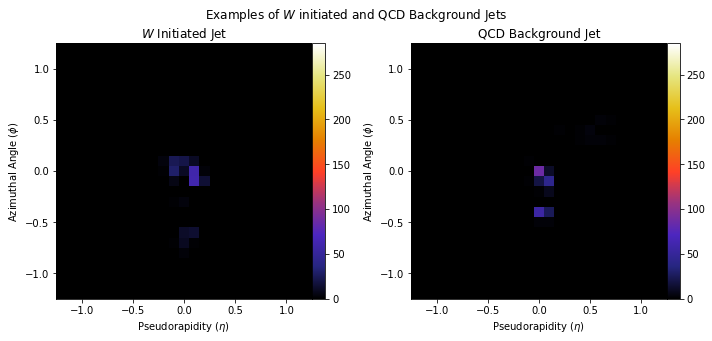

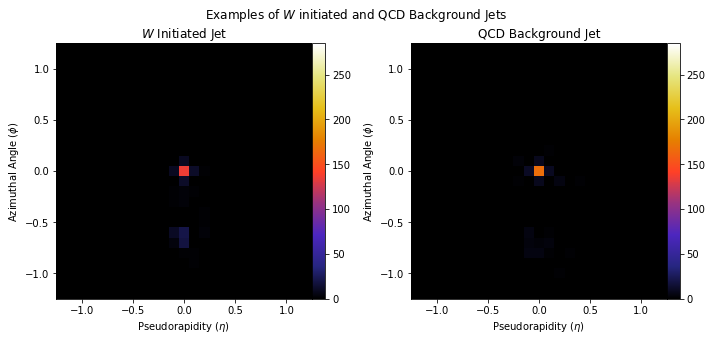

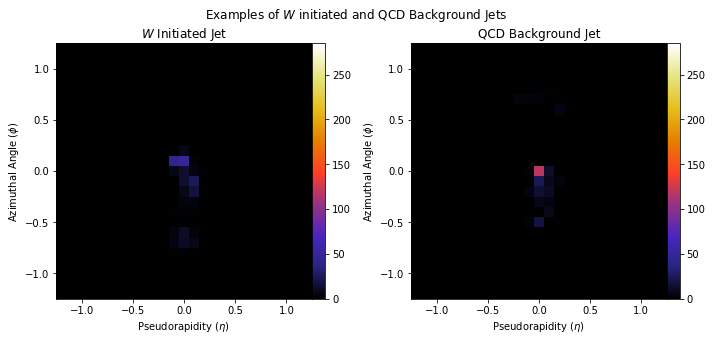

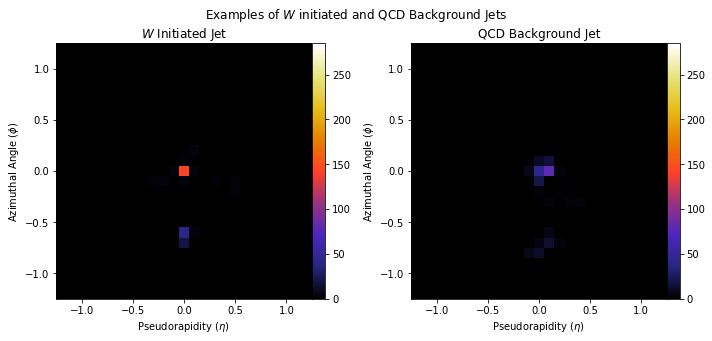

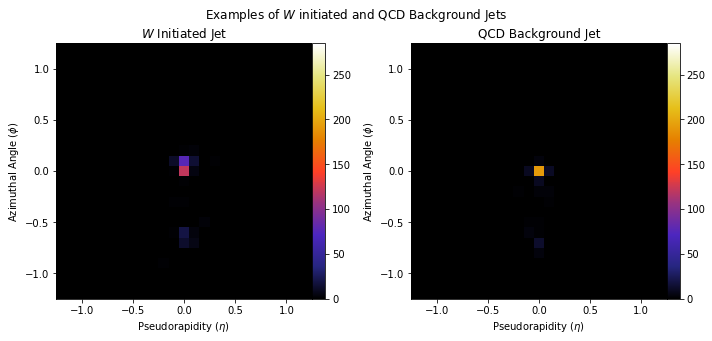

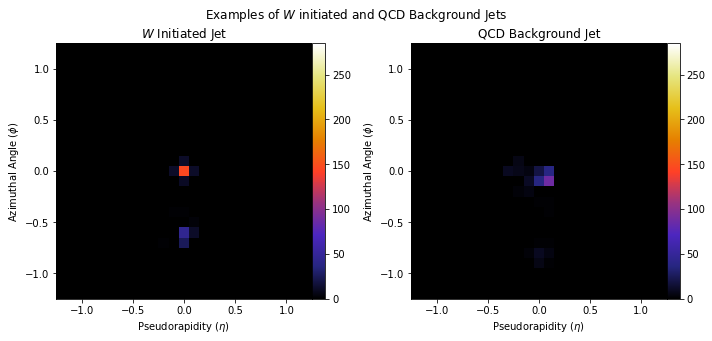

In [133]:
# Plot a few images chosen at random from the dataset
for ii in np.arange(0,6):
    fig, ax = plt.subplots(1,2, figsize=(10, 5)) # Create fig and axes objects
    # First plot
    plt.axes(ax[0]) # Change to first axis
    im0 = ax[0].imshow(jetIm[random.choice(W[0])],interpolation='none', extent=[-1.25, 1.25, -1.25, 1.25], cmap=cm.CMRmap,
                      vmin=minVal, vmax=maxVal)
    plt.colorbar(im0, fraction=0.0475, pad=0.001) # Add colorbar
    ax[0].set_title(r'$W$ Initiated Jet')
    ax[0].set_xlabel(r'Pseudorapidity $(\eta)$ ')
    ax[0].set_ylabel(r'Azimuthal Angle $(\phi)$')
    
    # Second plot
    plt.axes(ax[1]) # Change to second axis
    im1 = ax[1].imshow(jetIm[random.choice(QCD[0])], interpolation='none', extent=[-1.25, 1.25, -1.25, 1.25], cmap=cm.CMRmap,
                      vmin=minVal, vmax=maxVal)
    plt.colorbar(im1, fraction=0.0475, pad=0.001) # Add colorbar
    ax[1].set_title(r'QCD Background Jet')
    ax[1].set_xlabel(r'Pseudorapidity $(\eta)$ ')
    ax[1].set_ylabel(r'Azimuthal Angle $(\phi)$')
    plt.suptitle(r'Examples of $W$ initiated and QCD Background Jets')
    plt.tight_layout() # Colorbar and y-axis label of subplot 2 overlap without tight_layout()

In [ ]:
### Further Visualization of the 

## Deep, Feedforward Neural Network
Below is the code for the deep neural network devloped in class. 

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

plt.rcParams.update({'font.size': 20}) # Set plot font size

In [9]:
# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   lambda1 - L1 penalty coefficient (positive)
#
#   lambda2 - L2 penalty coefficient (positive)
#
#   batchSize - size of mini-batches for SGD
#
#   gamma - momentum coefficient (between 0 and 1)
#
#   initialization - a list specifying the initalization
#     ['normal', k] - standard normal random variables divided by k
#     ['uniform', a, b] - uniform random variables between a and b
#     'Nielsen' - standard normal random variables divided by the number of nodes in the next layer
#     ['LeCun', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(3/nodes in previous
#                                        layer) or lower/upper bounds of +/- the same, respectively
#     ['Glorot', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(1/mean of nodes in
#                                         previous and next layers) or lower/upper bounds of +/- the same, respectively
#     ['He', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(6/nodes in previous
#                                     layer) or lower/upper bounds of +/- the same, respectively
#
#   activations - string to choose which activation functions to use:
#     'sigmoid' - sigmoid function
#     'ReLU' - rectified linear unit
#     'ELU' - exponential linear unit
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, lambda1 = 0, lambda2 = 0, batchSize = 32, gamma = 0.0,
                 initialization = 'normal', activations = 'sigmoid', loss = 'sum-of-squares'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # momentum parameter
        self.gamma = gamma
        
        # activation type
        self.activation = activations
        
        # loss function
        self.loss = loss

        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        if initialization[0] == 'normal':
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/initialization[1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/initialization[1])
            
        if initialization[0] == 'uniform':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[-2] + 1, layers[-1])))
            
        if initialization == 'Nielsen':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/layers[i+1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/layers[-1])
            
        # LeCun, Glorot, and He initialization
        if initialization[0] in ['LeCun', 'Glorot', 'He']:
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                
                # define the limit term for normal random variables
                
                # LeCun initialization ("efficient backprop", default initialization in PyTorch)
                if initialization[0] == 'LeCun':
                    limit = np.sqrt(1.0 / layers[i+1])
                    
                # Glorot initialization (default initialization in Keras)
                elif initialization[0] == 'Glorot':
                    mean = (layers[i] + layers[i+1])/2.0
                    limit = np.sqrt(1.0 / mean)
                    
                # He initialization (typically used for very deep nets with PReLU activation)
                elif initialization[0] == 'He':
                    limit = np.sqrt(2.0 / layers[i+1])
                
                # generate the weights
                if initialization[1] == 'normal':
                    self.W.append(np.random.normal(0.0, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    
                elif initialization[1] == 'uniform':
                    limit *= np.sqrt(3.0)
                    self.W.append(np.random.uniform(-limit, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    

            # initialize weights between the last two layers (we don't want bias for the last one)

            # define the limit term for normal random variables
            if initialization[0] == 'LeCun':
                limit = np.sqrt(1.0 / layers[-2])
                
            elif initialization[0] == 'Glorot':
                mean = (layers[-2] + layers[-1])/2.0
                limit = np.sqrt(1.0 / mean)
                    
            elif initialization[0] == 'He':
                limit = np.sqrt(2.0 / layers[-2])
            
            # initialize the weights
            if initialization[1] == 'normal':
                self.W.append(np.random.normal(0.0, limit, size=(layers[-2] + 1, layers[-1])))
                
            elif initialization[1] == 'uniform':
                limit *= np.sqrt(3.0)
                self.W.append(np.random.uniform(-limit, limit, size=(layers[-2] + 1, layers[-1])))
        
    # define the activation function
    def activate(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1 + np.exp(-x))

        if self.activation == 'ReLU':
            return x*(x >= 0)
        
        if self.activation == 'ELU':
            return x*(x >= 0) + 0.1*(np.exp(x) - 1)*(x < 0)
    
    # define the activation derivative (where x is the INPUT to activation function)
    def activationDerivative(self, x):
        if self.activation == 'sigmoid':
            return self.activate(x) * (1 - self.activate(x))
        
        if self.activation == 'ReLU':
            return x >= 0
        
        if self.activation == 'ELU':
            return 1*(x >= 0) + 0.1*np.exp(x)*(x < 0)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000, printPerformance = True):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        testAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = LabelBinarizer().fit_transform(y)
        
        v = []
        for layer in np.arange(0,len(self.W)):
            v.append(np.zeros(self.W[layer].shape))
        
        startTime = time()
        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                Z = [np.atleast_2d(x)]
               #A = np.asarray(A)
                #A = np.reshape(A, (A.shape[1], A.shape[2]))
                #print('A shape initial', (A.shape))
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    #print('Net shape: ', net.shape)
                    out = self.activate(net)
                    #outshape = out.shape
                    #print('Activations: ', outshape)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    #print('Appended A shape: ', A.shape)
                    Z.append(net)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.activationDerivative(Z[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activationDerivative(Z[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    gradient = (A[layer].T.dot(D[layer])
                                + (self.lambda1/numberOfExamples)*np.sign(self.W[layer])
                                + (self.lambda2/numberOfExamples)*self.W[layer])
                    
                    v[layer] = self.gamma * v[layer] + self.alpha * gradient
                    self.W[layer] -= v[layer]
            
            loss = self.computeLoss(X,y)
            predictedY = self.predict(testX)
            predictedY = predictedY.argmax(axis=1)
            testAccuracy = accuracy_score(testY, predictedY)           

            predictedY = self.predict(trainX)
            predictedY = predictedY.argmax(axis=1)
            trainAccuracy = accuracy_score(trainY, predictedY)

            testAccuracies.append(testAccuracy)
            trainAccuracies.append(trainAccuracy)
            losses.append(loss)
                
            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:
                if printPerformance: # if we chose, compute the accuracy (this makes it run slower)
                    print("[INFO] epoch = {}, loss = {:.6f}, training accuracy = {:.6f}, test accuracy = {:.6f}".format(epoch + 1, loss, trainAccuracy, testAccuracy))
                
                else: # otherwise, simply print the training loss
                    losses.append(loss)
                    print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))
        
           
                
        endTime = time()
        self.compTime = endTime - startTime
        print('[INFO] Total computation time: {:.3f}'.format(self.compTime))
        
        # if we chose to print the performance, plot loss, training accuracy, and test accuracy for each epoch
        if printPerformance:
            fig, ax1 = plt.subplots(figsize=(15,10))

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, 1), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')
            if epochs >= 10000:
                ax1.set_xscale('log')
                
            ax1.grid('both')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, 1), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, 1), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)

        self.finalAccuraciesTest = testAccuracies[-1] # Store final testing accuracy
        self.finalAccuraciesTrain = trainAccuracies[-1] # Store final training accuracy
        
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activate(np.dot(p, self.W[layer]))
            
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
            
        # if there is an L1 penalty, compute it and add it to the loss
        if self.lambda1 != 0:
            # compute the L1 penalty 
            L1penalty = 0

            for layer in np.arange(0,len(self.W)):
                L1penalty += np.sum(np.abs(self.W[layer]))
        
            # add the L1 penalty to the loss
            loss = loss + (self.lambda1 / X.shape[0]) * L1penalty
            
        # if there is an L2 penalty, compute it and add it to the loss
        if self.lambda2 != 0:
            # compute the L2 penalty 
            L2penalty = 0

            for layer in np.arange(0,len(self.W)):
                L2penalty += np.sum(self.W[layer] ** 2)
        
            # add the L2 penalty to the loss
            loss = loss + (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

### Splitting the Data
Because the W and QCD jets are not randomly mixed in the dataset, we will need to select our training data using the keys.

In [10]:
# Splitting the data
numIm  = 5000  # Number of images to train/validate
inputs = 25*25 # pixels (input nodes) 

halfNumIm = int(numIm / 2) # Half of data for QCD, half for W

jetIndRandW   = np.random.choice(W[0][:],halfNumIm)   # Return values (indices) of randomly selected image numbers
jetIndRandQCD = np.random.choice(QCD[0][:],halfNumIm) # Return values (indices) of randomly selected image numbers


In [11]:
JetDataW     = np.take(jetIm, jetIndRandW, axis=0)
JetDataQCD   = np.take(jetIm, jetIndRandQCD, axis=0)
labelIndices = np.concatenate((jetIndRandW, jetIndRandQCD))
JetLInput    = np.take(jetLabels, labelIndices)

# Confirm dimensions
print('Shape of W data: {}'.format(JetDataW.shape))
print('Shape of QCD data: {}'.format(JetDataQCD.shape))
print('Shape of input label data: {}'.format(JetLInput.shape))

Shape of W data: (2500, 25, 25)
Shape of QCD data: (2500, 25, 25)
Shape of input label data: (5000,)


In [12]:
# Concatenate W and QCD image arrays
X = np.concatenate((JetDataW, JetDataQCD), axis=0) 
X = X.reshape([numIm, inputs]) # Reshape to match input nodes
print('Shape of input data {}'.format(X.shape)) 

# Scale to [0,1]
X = X / maxVal

Shape of input data (5000, 625)


### Sanity Check 
To keep track of all of the indices, we note that we took the images from the array `jetIm` in the order of the `jetIndRandW` array for the $W$ data. An identical operation was performed for the QCD image set. Note that this preserves the order of the labels stored in the concatenated array `labelIndices`. Thus, when this data is fed into the `train_test_split()` function, the labels are in the order of the input data, so the image data and the corresponding labels align. Now, let's split the data.

In [13]:
# First split the data into 80/20
(tempX, testX, tempY, testY) = train_test_split(X, JetLInput, test_size = 0.20, random_state = 1) # Set seed to 1 for reproducibility

# Split 80% testing into 60% (75% of 80) training, 20% validation (25% of 80)
(trainX, validX, trainY, validY) = train_test_split(tempX, tempY, test_size = 0.25, random_state = 1)

### Initial Run
Here, we will run the network once with the best hyperparameters obtained from my fourth homework assignment.

[INFO] epoch = 100, loss = 1248.995978, training accuracy = 0.485333, test accuracy = 0.537000
[INFO] epoch = 200, loss = 730.582859, training accuracy = 0.486333, test accuracy = 0.538000
[INFO] epoch = 300, loss = 725.107046, training accuracy = 0.580333, test accuracy = 0.598000
[INFO] epoch = 400, loss = 719.720651, training accuracy = 0.590667, test accuracy = 0.595000
[INFO] epoch = 500, loss = 714.196536, training accuracy = 0.598667, test accuracy = 0.601000
[INFO] epoch = 600, loss = 708.412338, training accuracy = 0.601667, test accuracy = 0.607000
[INFO] epoch = 700, loss = 702.230645, training accuracy = 0.606667, test accuracy = 0.610000
[INFO] epoch = 800, loss = 695.500202, training accuracy = 0.616000, test accuracy = 0.614000
[INFO] epoch = 900, loss = 688.058055, training accuracy = 0.622333, test accuracy = 0.616000
[INFO] epoch = 1000, loss = 679.693838, training accuracy = 0.627333, test accuracy = 0.619000
[INFO] Total computation time: 85.226


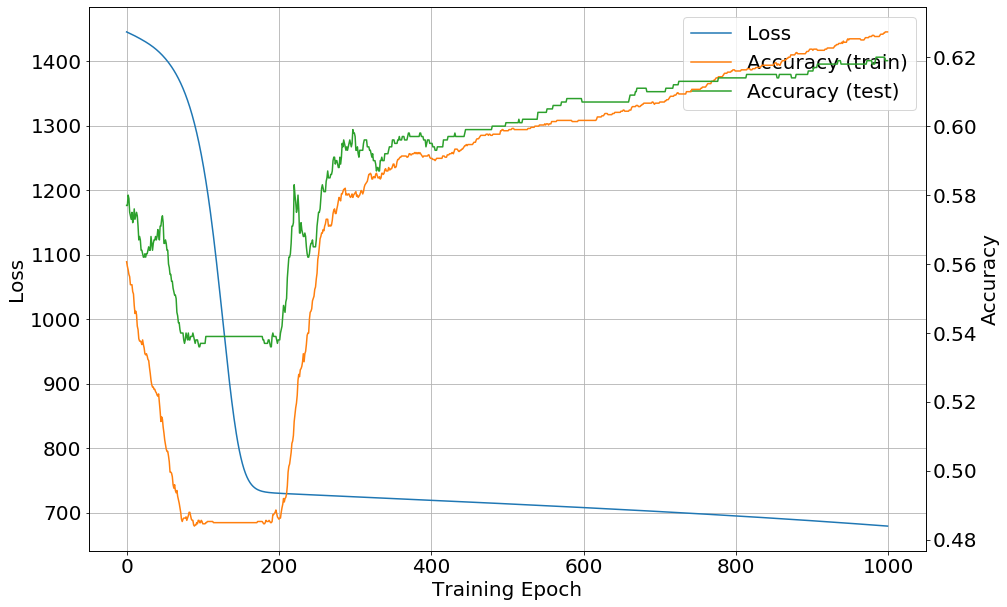

In [13]:
model = FeedforwardNeuralNetwork([inputs, 32, 32, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

In [14]:
print('##############################')
print('###### TRAINING RESULTS ######')
print('##############################')
#trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
#trainYtemp = trainY.argmax(axis=1)
print(classification_report(trainY, predictedY))

print('##############################')
print('##### VALIDATION RESULTS #####')
print('##############################')
#testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(validX)
predictedY = predictedY.argmax(axis=1)
#validYtemp = validY.argmax(axis=1)
print(classification_report(validY, predictedY))

##############################
###### TRAINING RESULTS ######
##############################
              precision    recall  f1-score   support

         0.0       0.64      0.62      0.63      1545
         1.0       0.61      0.64      0.62      1455

    accuracy                           0.63      3000
   macro avg       0.63      0.63      0.63      3000
weighted avg       0.63      0.63      0.63      3000

##############################
##### VALIDATION RESULTS #####
##############################
              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59       461
         1.0       0.65      0.63      0.64       539

    accuracy                           0.62      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.62      0.62      0.62      1000



### Discussion
Overall this isn't too bad to begin with: the training and validation set accuracies are roughly equal. From the output plot, it looks like varying the momentum parameter could help significantly, so let's scan the momentum hyperparameter space first. Before moving further, let's see if we can narrow down a good architecture for this dataset.

#### Doubling the Values of the Current (2) Hidden Layers

[INFO] epoch = 100, loss = 967.887676, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 200, loss = 732.573281, training accuracy = 0.472667, test accuracy = 0.532000
[INFO] epoch = 300, loss = 726.819325, training accuracy = 0.420333, test accuracy = 0.413000
[INFO] epoch = 400, loss = 721.175613, training accuracy = 0.425333, test accuracy = 0.408000
[INFO] epoch = 500, loss = 715.419232, training accuracy = 0.428000, test accuracy = 0.408000
[INFO] epoch = 600, loss = 709.245306, training accuracy = 0.438333, test accuracy = 0.416000
[INFO] epoch = 700, loss = 702.730027, training accuracy = 0.437667, test accuracy = 0.418000
[INFO] epoch = 800, loss = 695.683996, training accuracy = 0.436333, test accuracy = 0.416000
[INFO] epoch = 900, loss = 687.905764, training accuracy = 0.431667, test accuracy = 0.417000
[INFO] epoch = 1000, loss = 679.257976, training accuracy = 0.426000, test accuracy = 0.412000
[INFO] Total computation time: 130.569


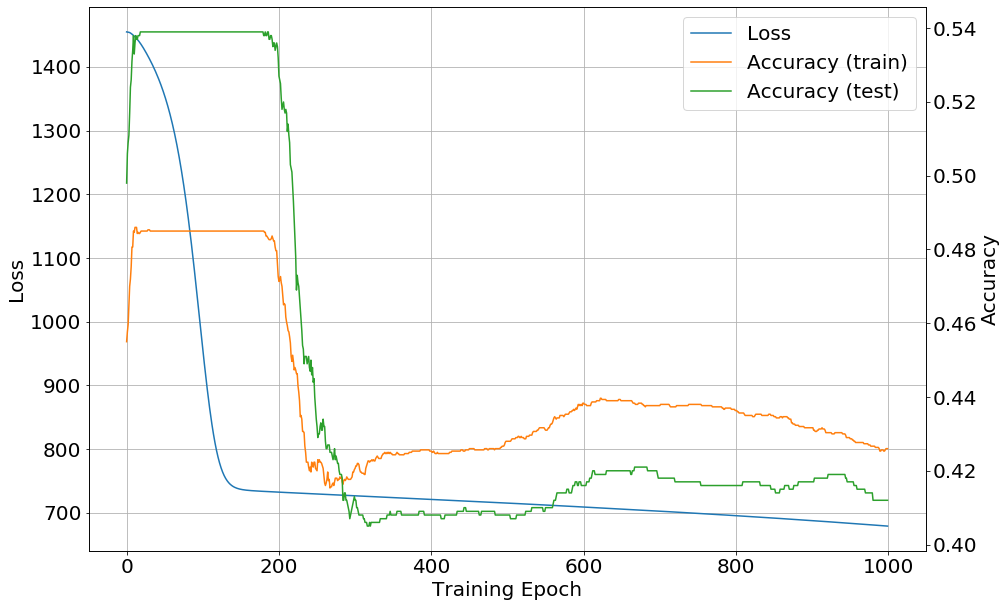

In [15]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

#### Adding a third layer
We see from the previous output that adding a third layer improved the testing accuracy by 2%, so perhaps a third layer will help the network learn the data better.

[INFO] epoch = 100, loss = 1456.245197, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 200, loss = 1455.834941, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 300, loss = 1446.440662, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 400, loss = 1399.182826, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 500, loss = 1128.778828, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 600, loss = 729.979768, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 700, loss = 721.797366, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 800, loss = 715.979313, training accuracy = 0.417333, test accuracy = 0.465000
[INFO] epoch = 900, loss = 709.955737, training accuracy = 0.391333, test accuracy = 0.433000
[INFO] epoch = 1000, loss = 703.392524, training accuracy = 0.387000, test accuracy = 0.428000
[INFO] Total computation time: 151.980


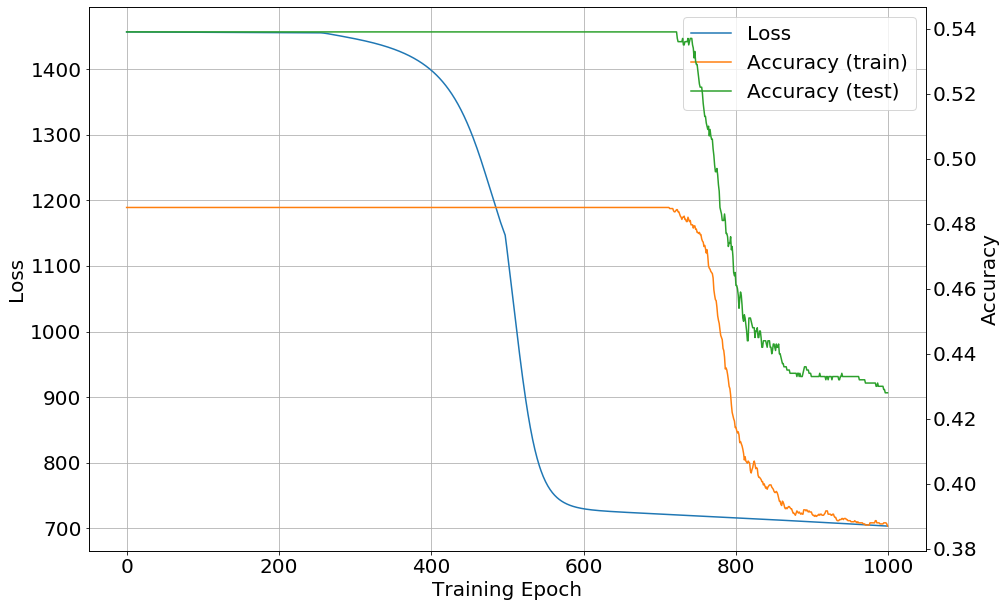

In [16]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 64, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

#### Halving the nodes in the last hidden layer
Since this didn't help much, let's see if decreasing the width of the last layer will help.

[INFO] epoch = 100, loss = 1443.380697, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 200, loss = 1410.895374, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 300, loss = 1028.010841, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 400, loss = 727.608300, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 500, loss = 721.765842, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 600, loss = 716.580697, training accuracy = 0.578667, test accuracy = 0.601000
[INFO] epoch = 700, loss = 711.150087, training accuracy = 0.624000, test accuracy = 0.638000
[INFO] epoch = 800, loss = 705.286430, training accuracy = 0.629000, test accuracy = 0.643000
[INFO] epoch = 900, loss = 698.789979, training accuracy = 0.646000, test accuracy = 0.645000
[INFO] epoch = 1000, loss = 691.405619, training accuracy = 0.663000, test accuracy = 0.656000
[INFO] Total computation time: 141.433


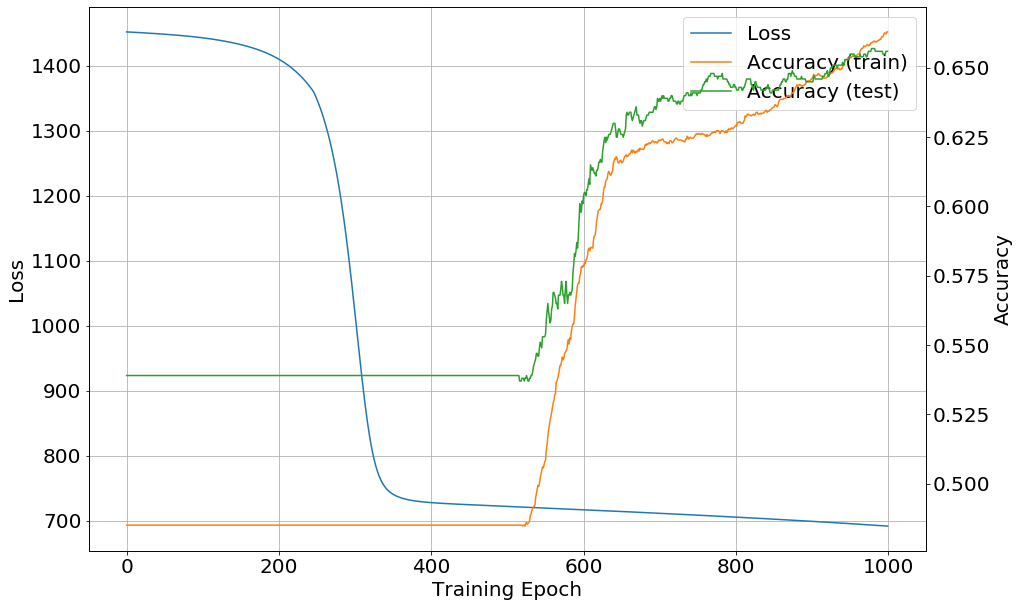

In [17]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

#### Adding a fourth layer of 32 nodes
Decreasing the nodes seemed to help quite a bit; so far, our highest testing accuracy is with 65% from the previous output. Let's try adding a fourth layer with 32 nodes.


[INFO] epoch = 100, loss = 1452.092371, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 200, loss = 1449.189653, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 300, loss = 1442.411968, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 400, loss = 1418.525517, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 500, loss = 1169.192074, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 600, loss = 734.314746, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 700, loss = 729.015730, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 800, loss = 723.788035, training accuracy = 0.416333, test accuracy = 0.402000
[INFO] epoch = 900, loss = 718.448933, training accuracy = 0.389333, test accuracy = 0.396000
[INFO] epoch = 1000, loss = 712.849779, training accuracy = 0.381667, test accuracy = 0.385000
[INFO] Total computation time: 157.046


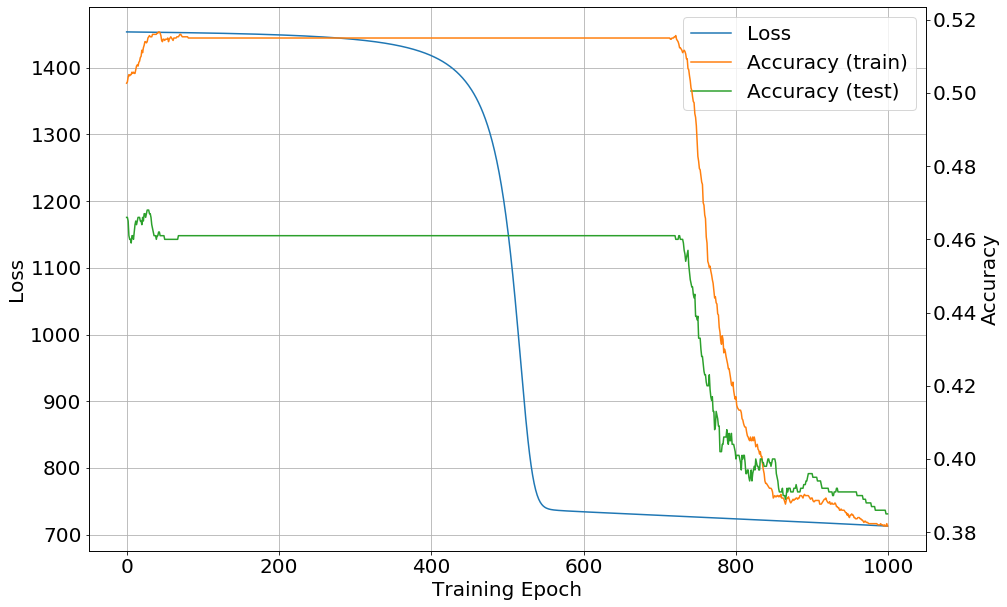

In [18]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 32, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

#### Halving the width of the fourth layer
Adding  the fourth layer seemed to hurt the performance of the model. Following previous success, let's halve the nodes in the fourth layer.

[INFO] epoch = 100, loss = 1451.767097, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 200, loss = 1448.996456, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 300, loss = 1442.256500, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 400, loss = 1418.968903, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 500, loss = 1194.391867, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 600, loss = 728.199810, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 700, loss = 723.209604, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 800, loss = 718.154790, training accuracy = 0.581667, test accuracy = 0.528000
[INFO] epoch = 900, loss = 712.828350, training accuracy = 0.674333, test accuracy = 0.656000
[INFO] epoch = 1000, loss = 707.102159, training accuracy = 0.673667, test accuracy = 0.660000
[INFO] Total computation time: 151.667


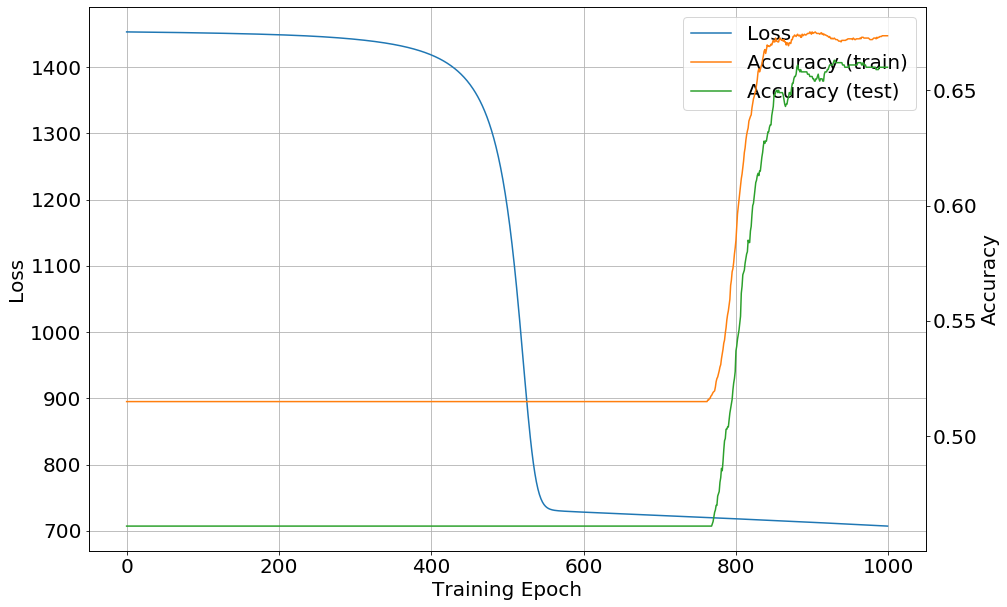

In [19]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 16, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

#### Adding a fifth layer with double the nodes of the (current) first hidden layer
This is a very interesting result. We see that we achieved a maximum testing accuracy of 66% at epoch 1000, where both accuracies plateaued. Perhaps adding a fifth layer, with 128 nodes will increase the performance.

[INFO] epoch = 100, loss = 1455.055055, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 200, loss = 1455.002963, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 300, loss = 1454.946622, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 400, loss = 1454.885462, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 500, loss = 1454.819116, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 600, loss = 1454.745758, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 700, loss = 1454.663123, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 800, loss = 1454.567934, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 900, loss = 1454.456245, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 1000, loss = 1454.322848, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] Total computation time: 259.382


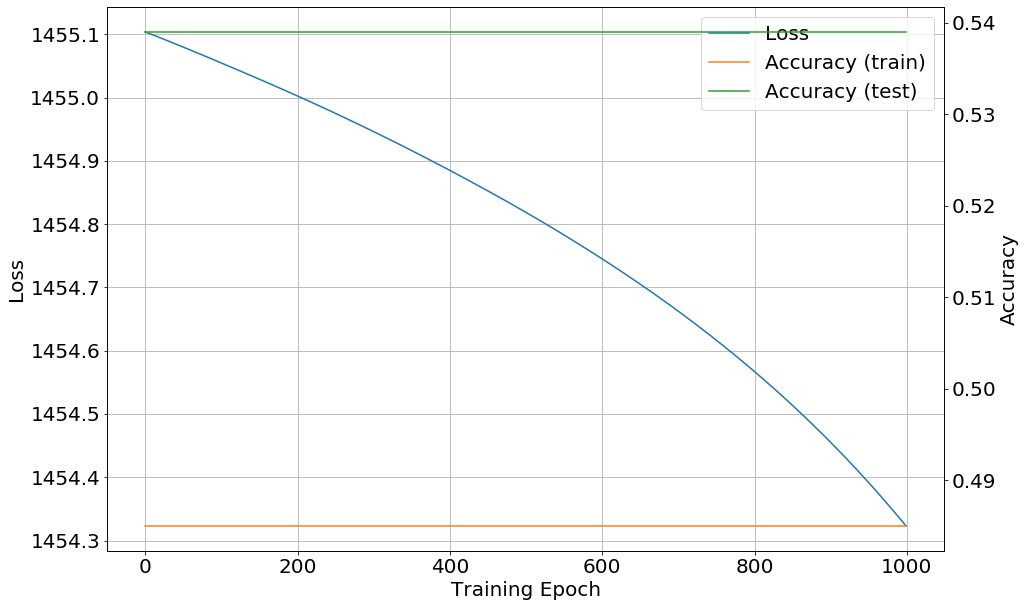

In [20]:
model = FeedforwardNeuralNetwork([inputs, 128, 64, 64, 32, 16, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

### Adding a sixth layer with double the nodes
We can see that adding the fifth layer with 128 nodes wasn't beneficial until roughly the 600th epoch, where the growth of both accuracies started increasing exponentially. It will be interesting to see the effect of a sixth layer with double the nodes of the (current) first hidden layer. Note that there is, of course, a tradeoff between performance of the network and computation time; the computation time with the fifth layer was longer by 100 s. However, in the interest of finding the best testing accuracy, let's try adding another layer with 256 nodes.

[INFO] epoch = 100, loss = 1455.334500, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 200, loss = 1455.318892, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 300, loss = 1455.299208, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 400, loss = 1455.267071, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 500, loss = 1455.212023, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 600, loss = 1455.142969, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 700, loss = 1455.071478, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 800, loss = 1454.998303, training accuracy = 0.485000, test accuracy = 0.539000
[INFO] epoch = 900, loss = 1454.919676, training accuracy = 0.474333, test accuracy = 0.531000
[INFO] epoch = 1000, loss = 1454.830172, training accuracy = 0.439000, test accuracy = 0.491000
[INFO] Total computation time: 483.505


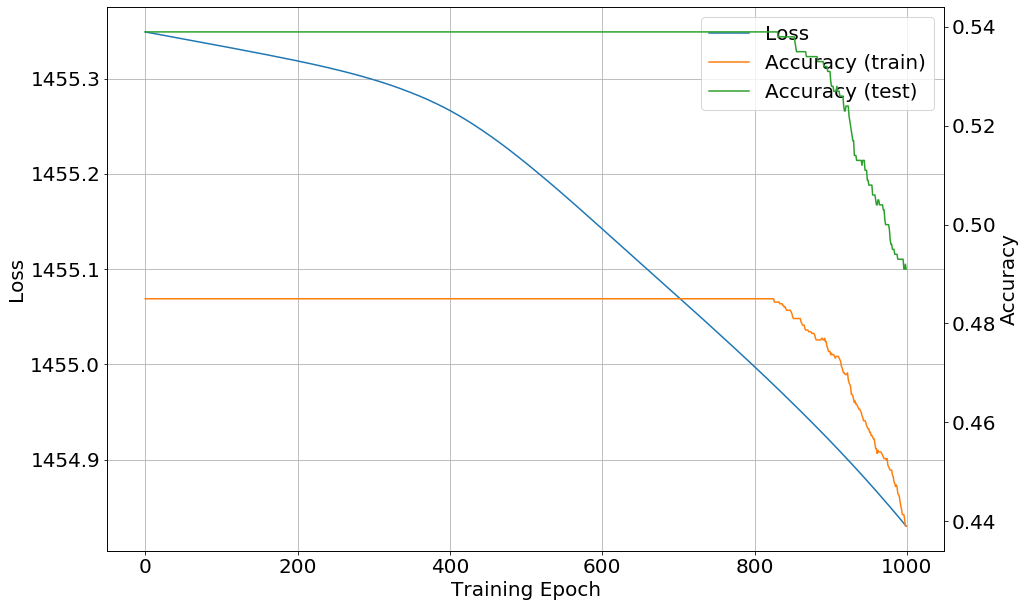

In [21]:
model = FeedforwardNeuralNetwork([inputs, 256, 128, 64, 64, 32, 16, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

### Adding a seventh layer with 8 nodes

[INFO] epoch = 100, loss = 1455.369515, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 200, loss = 1455.369198, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 300, loss = 1455.368880, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 400, loss = 1455.368561, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 500, loss = 1455.368242, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 600, loss = 1455.367921, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 700, loss = 1455.367599, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 800, loss = 1455.367276, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 900, loss = 1455.366952, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 1000, loss = 1455.366626, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] Total computation time: 504.975


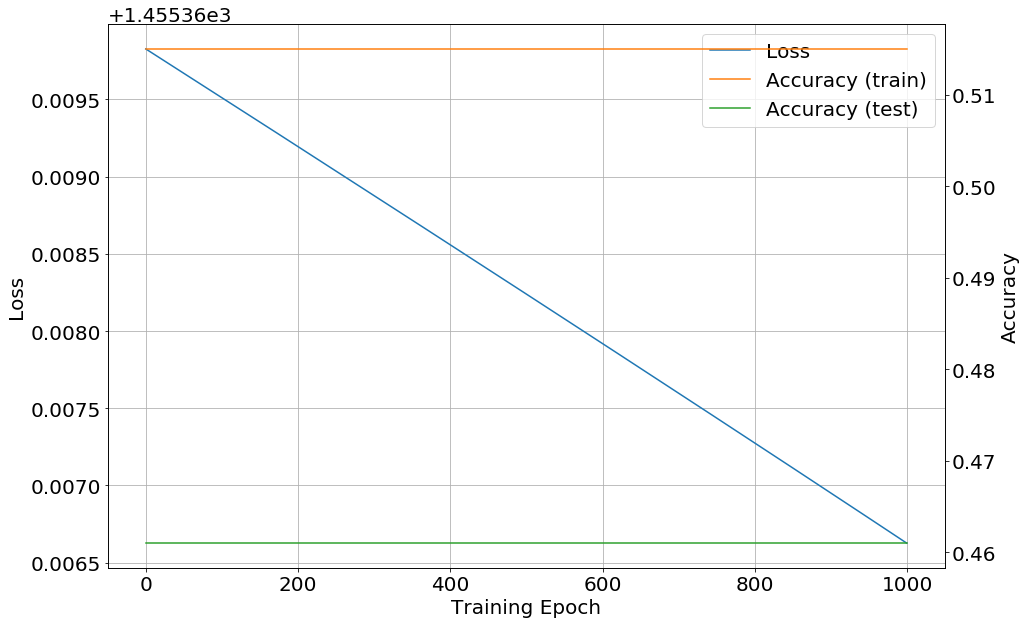

In [23]:
model = FeedforwardNeuralNetwork([inputs, 256, 128, 64, 64, 32, 16, 8, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

[INFO] epoch = 100, loss = 1455.373259, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 200, loss = 1455.373227, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 300, loss = 1455.373195, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 400, loss = 1455.373163, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 500, loss = 1455.373131, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 600, loss = 1455.373099, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 700, loss = 1455.373067, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 800, loss = 1455.373035, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 900, loss = 1455.373004, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 1000, loss = 1455.372972, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] Total computation time: 525.009


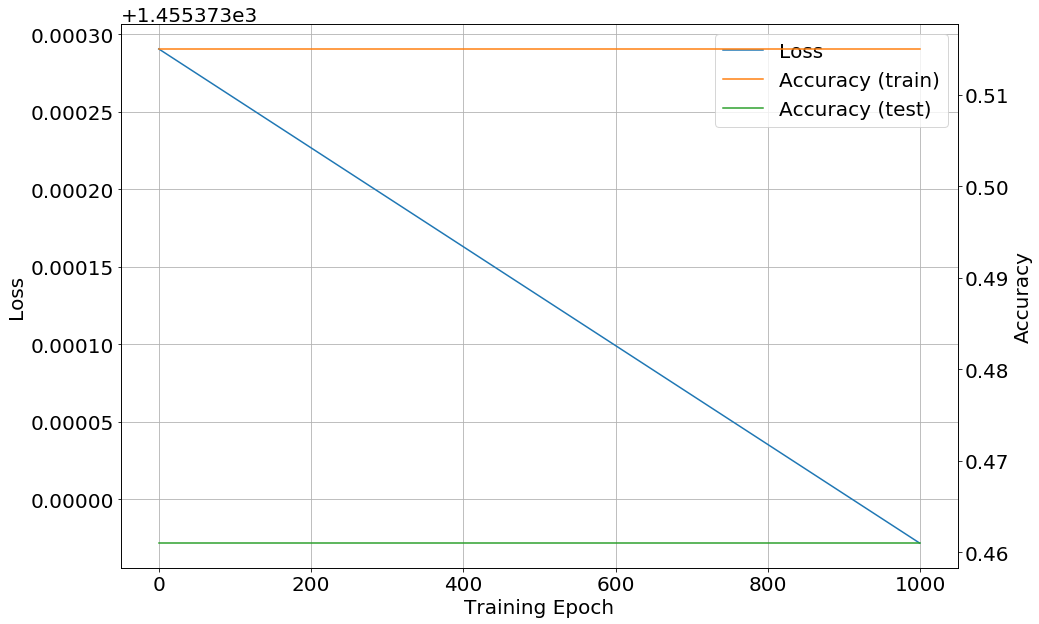

In [24]:
model = FeedforwardNeuralNetwork([inputs, 256, 128, 64, 64, 32, 16, 8, 4, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

[INFO] epoch = 100, loss = 1455.867926, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 200, loss = 1455.866480, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 300, loss = 1455.864902, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 400, loss = 1455.863185, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 500, loss = 1455.861302, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 600, loss = 1455.859245, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 700, loss = 1455.856991, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 800, loss = 1455.854516, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 900, loss = 1455.851841, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 1000, loss = 1455.849004, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] Total computation time: 1126.053


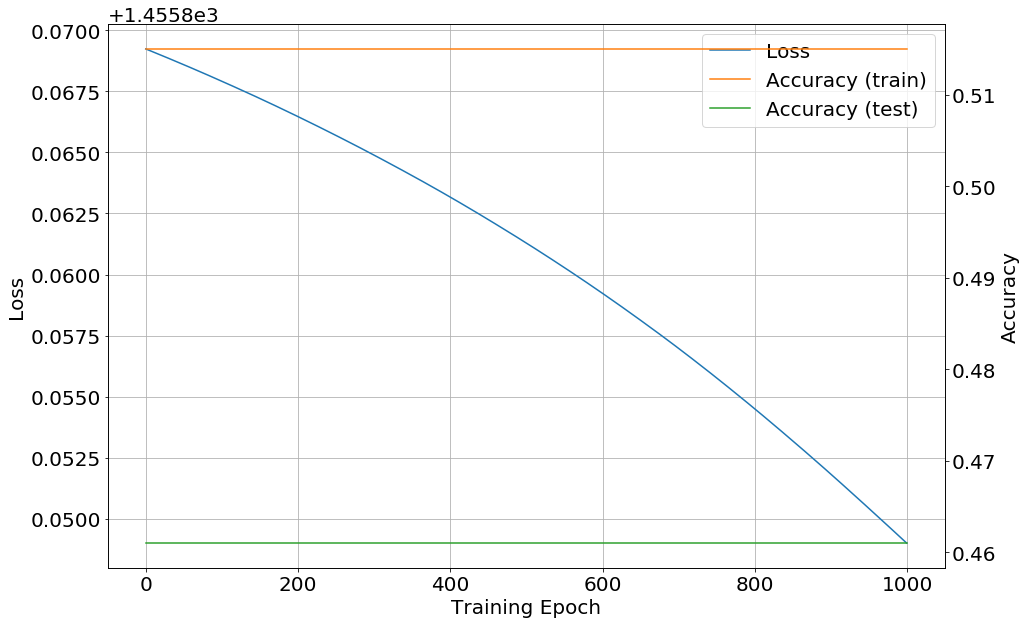

In [25]:
model = FeedforwardNeuralNetwork([inputs, 512, 256, 128, 64, 64, 32, 16, 8, 2], 0.00001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

#### Discussion
So far, the best results is the network with architecture $[\textrm{inputs},\, 64,\, 64,\, 32,\, 2]$, as evidenced by the linearly increasing trend of the validating and training accuracies (a maximum testing accuracy was achieved at epoch 1000 with 65.6%). Now, let's try altering the learning rate $\alpha$.

[INFO] epoch = 100, loss = 698.866960, training accuracy = 0.496667, test accuracy = 0.522000
[INFO] epoch = 200, loss = 556.896008, training accuracy = 0.480667, test accuracy = 0.476000
[INFO] epoch = 300, loss = 528.558315, training accuracy = 0.484000, test accuracy = 0.506000
[INFO] epoch = 400, loss = 511.201735, training accuracy = 0.412000, test accuracy = 0.453000
[INFO] epoch = 500, loss = 499.584078, training accuracy = 0.372667, test accuracy = 0.418000
[INFO] epoch = 600, loss = 494.038584, training accuracy = 0.371333, test accuracy = 0.415000
[INFO] epoch = 700, loss = 483.414238, training accuracy = 0.413000, test accuracy = 0.451000
[INFO] epoch = 800, loss = 481.788840, training accuracy = 0.431000, test accuracy = 0.472000
[INFO] epoch = 900, loss = 472.872986, training accuracy = 0.436333, test accuracy = 0.470000
[INFO] epoch = 1000, loss = 474.059234, training accuracy = 0.395667, test accuracy = 0.430000
[INFO] Total computation time: 149.740


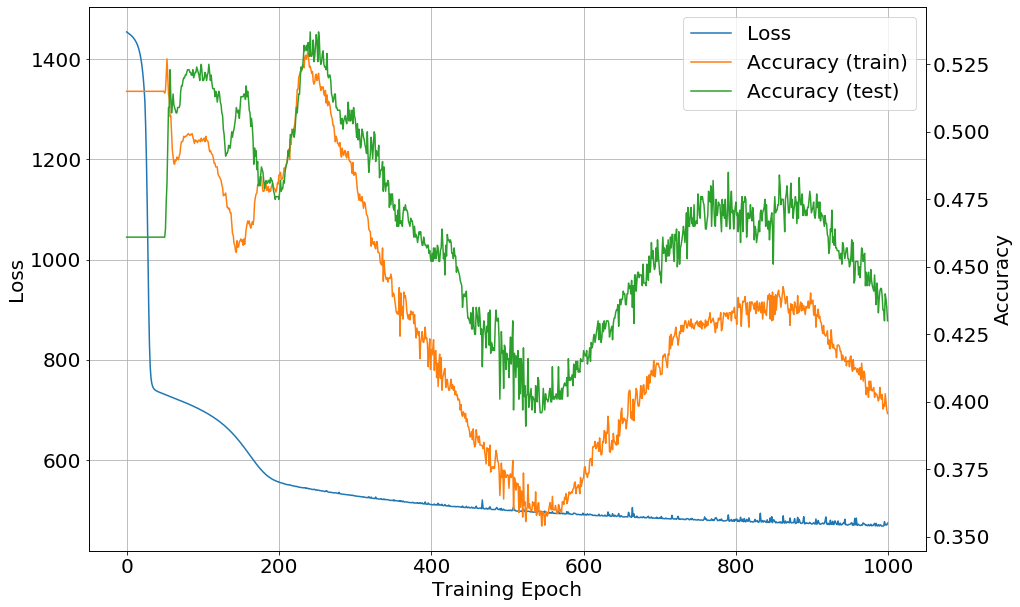

In [26]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 0.1, 0.1, 32, 0.2, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

### Discussion
Clearly, that didn't help much. Let's return the learning rate to it's default and try modifying the momentum parameter. For this, a quick scan of the the momentum hyperparameter space will be sufficient.

Iteration: 0
Momemtum = 0.0
[INFO] epoch = 100, loss = 1449.280795, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 200, loss = 1440.206599, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 300, loss = 1415.184764, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 400, loss = 1169.630588, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 500, loss = 735.575810, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 600, loss = 728.471357, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 700, loss = 723.868828, training accuracy = 0.514333, test accuracy = 0.460000
[INFO] epoch = 800, loss = 719.249006, training accuracy = 0.446667, test accuracy = 0.448000
[INFO] epoch = 900, loss = 714.517399, training accuracy = 0.439333, test accuracy = 0.429000
[INFO] epoch = 1000, loss = 709.553346, training accuracy = 0.432667, test accuracy = 0.425000
[INFO] Total computation ti

[INFO] epoch = 200, loss = 706.655036, training accuracy = 0.434333, test accuracy = 0.433000
[INFO] epoch = 300, loss = 674.865753, training accuracy = 0.418333, test accuracy = 0.419000
[INFO] epoch = 400, loss = 612.075006, training accuracy = 0.372333, test accuracy = 0.380000
[INFO] epoch = 500, loss = 559.625120, training accuracy = 0.349000, test accuracy = 0.373000
[INFO] epoch = 600, loss = 546.223031, training accuracy = 0.357667, test accuracy = 0.366000
[INFO] epoch = 700, loss = 536.655829, training accuracy = 0.351000, test accuracy = 0.374000
[INFO] epoch = 800, loss = 528.118892, training accuracy = 0.341000, test accuracy = 0.373000
[INFO] epoch = 900, loss = 520.373566, training accuracy = 0.326667, test accuracy = 0.377000
[INFO] epoch = 1000, loss = 514.024013, training accuracy = 0.314333, test accuracy = 0.345000
[INFO] Total computation time: 162.587
Iteration: 9
Momemtum = 0.8999999999999999
[INFO] epoch = 100, loss = 721.727870, training accuracy = 0.395333, te

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in multiply


[INFO] epoch = 200, loss = nan, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 300, loss = nan, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 400, loss = nan, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 500, loss = nan, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 600, loss = nan, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 700, loss = nan, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 800, loss = nan, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 900, loss = nan, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] epoch = 1000, loss = nan, training accuracy = 0.515000, test accuracy = 0.461000
[INFO] Total computation time: 130.398


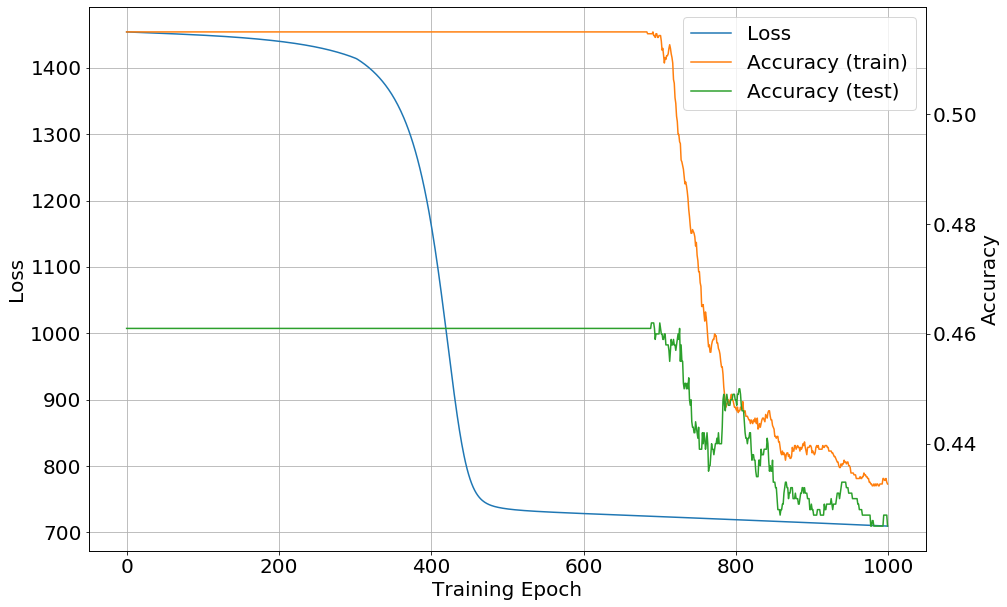

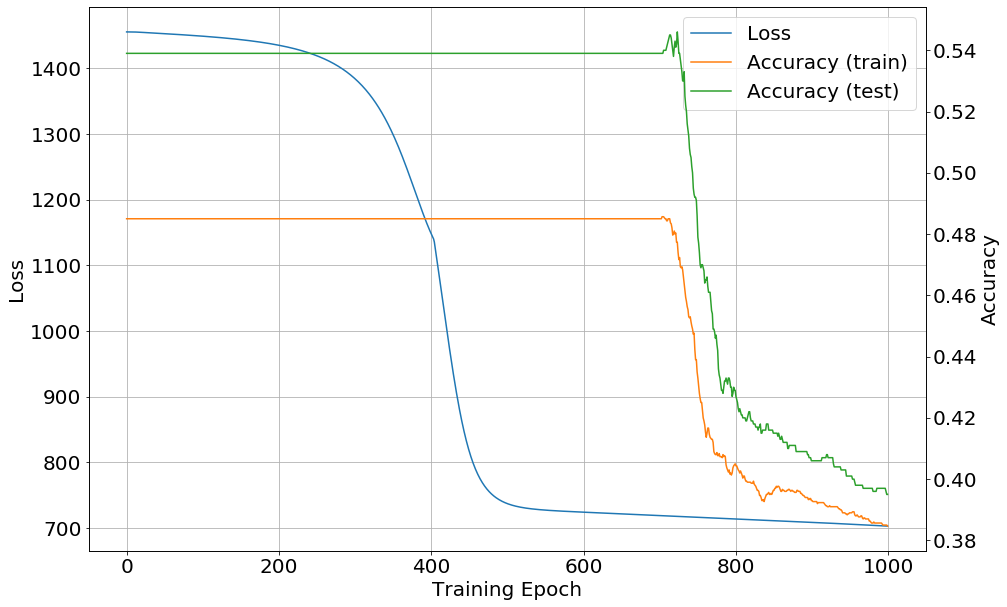

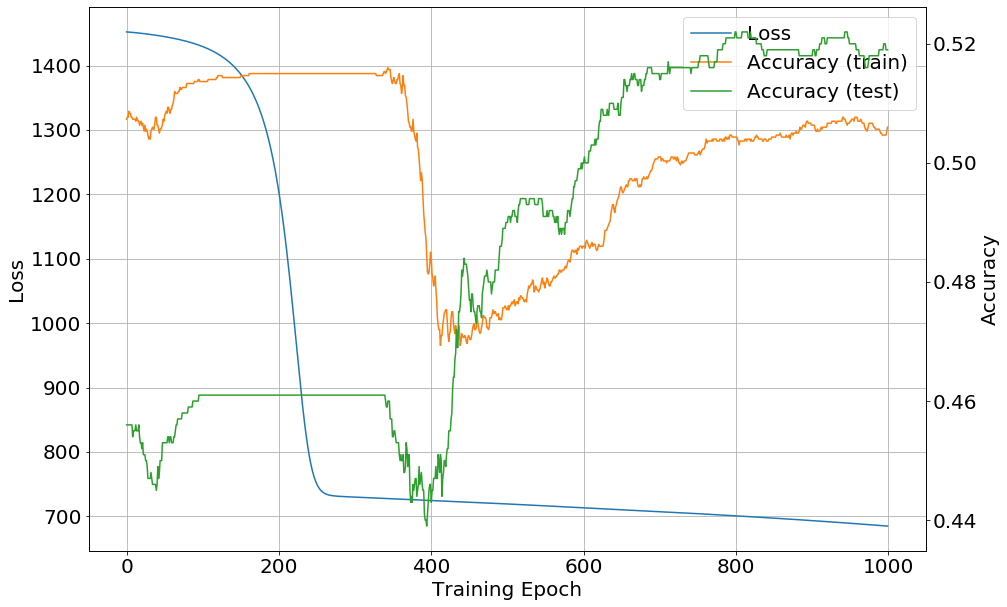

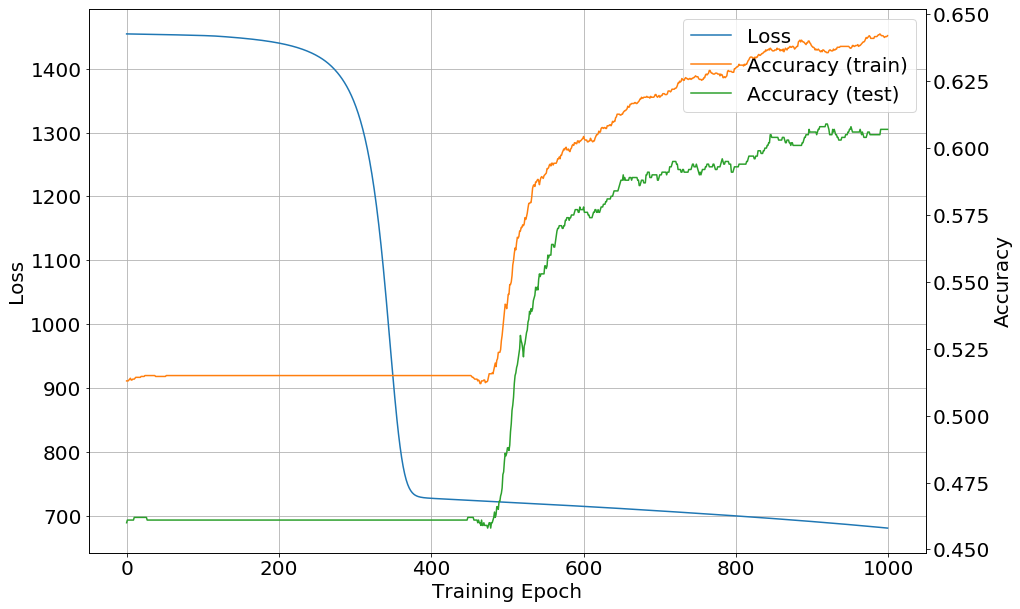

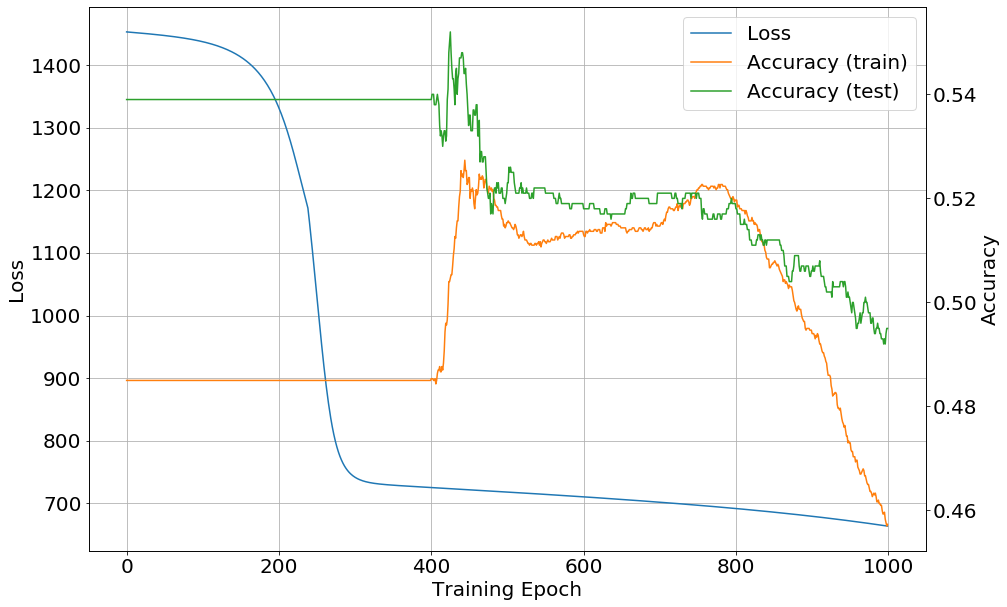

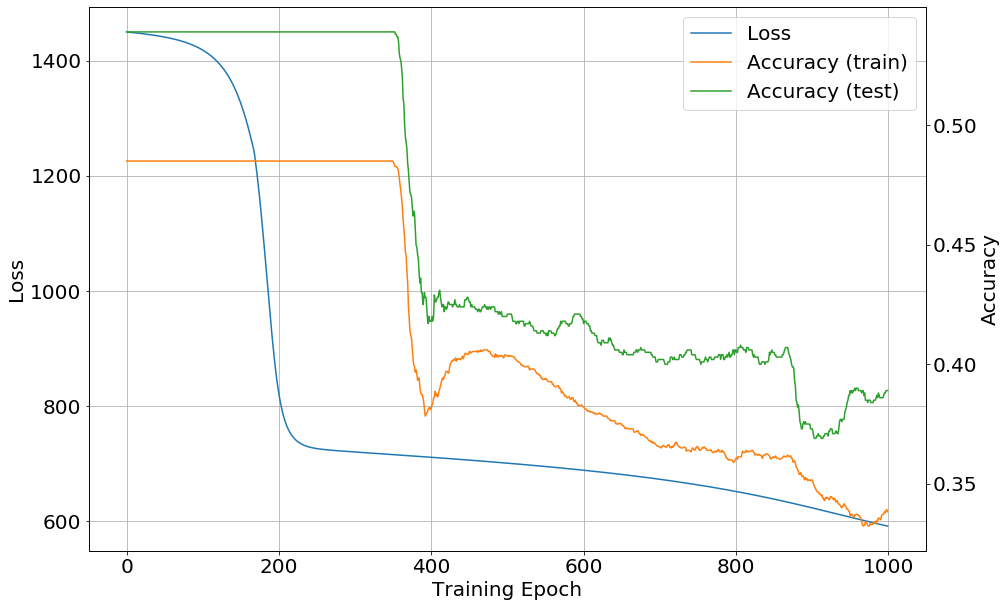

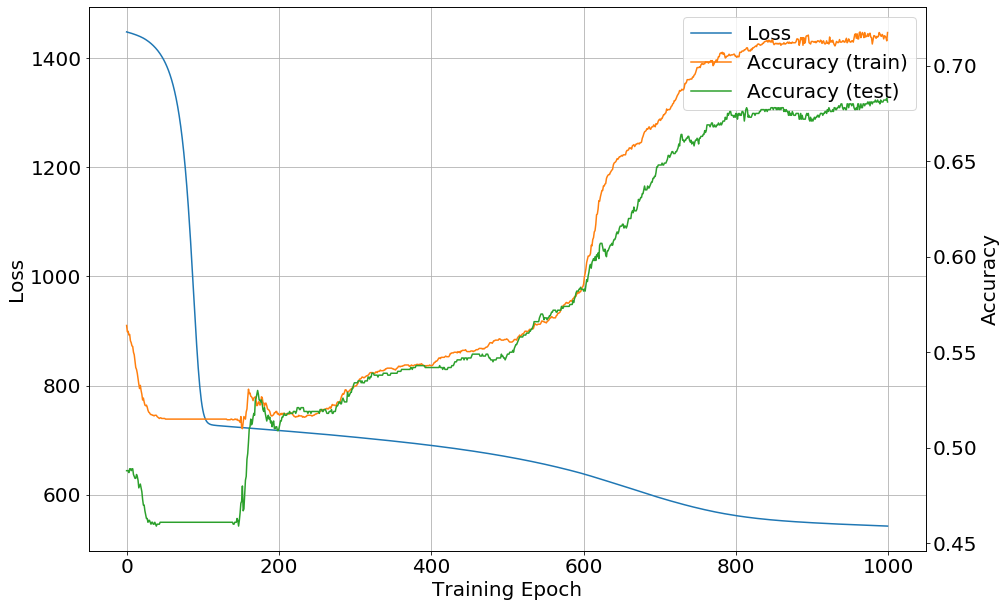

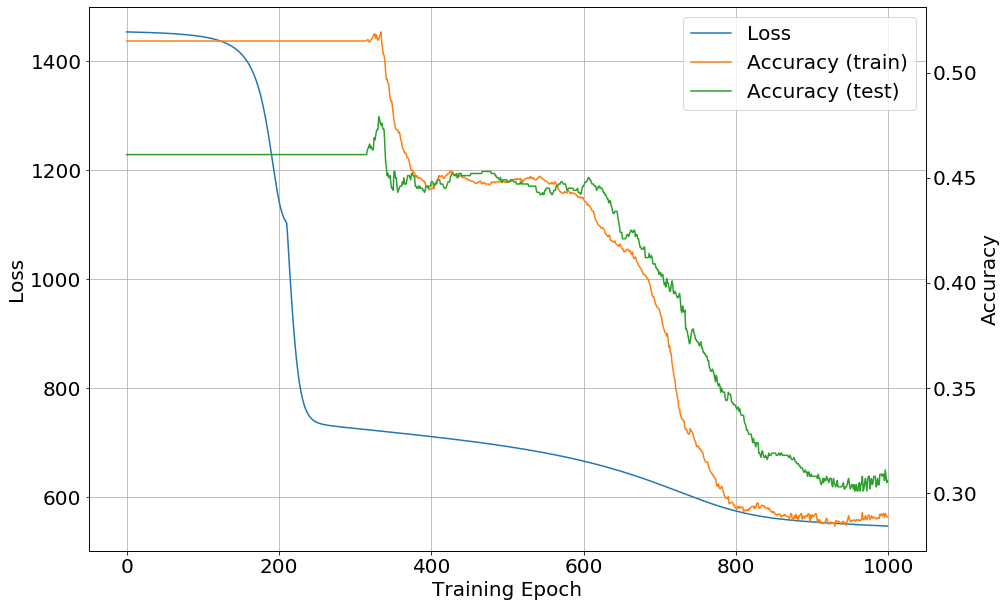

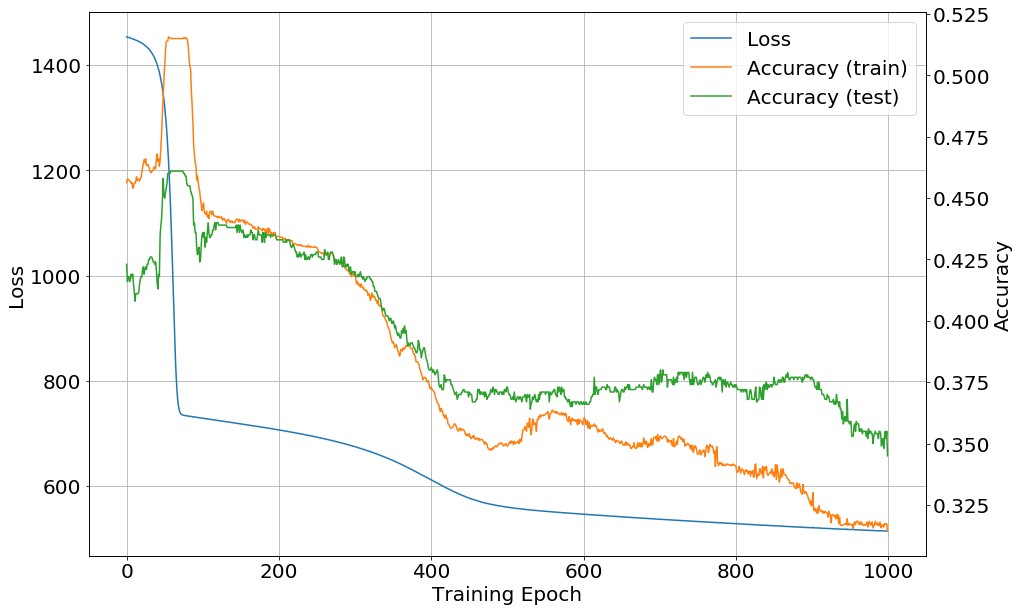

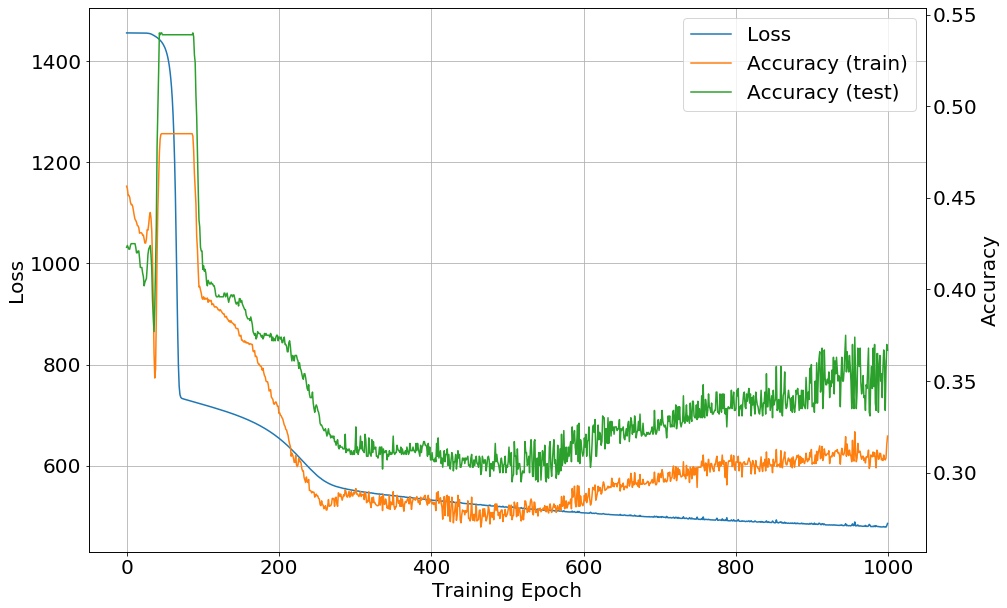

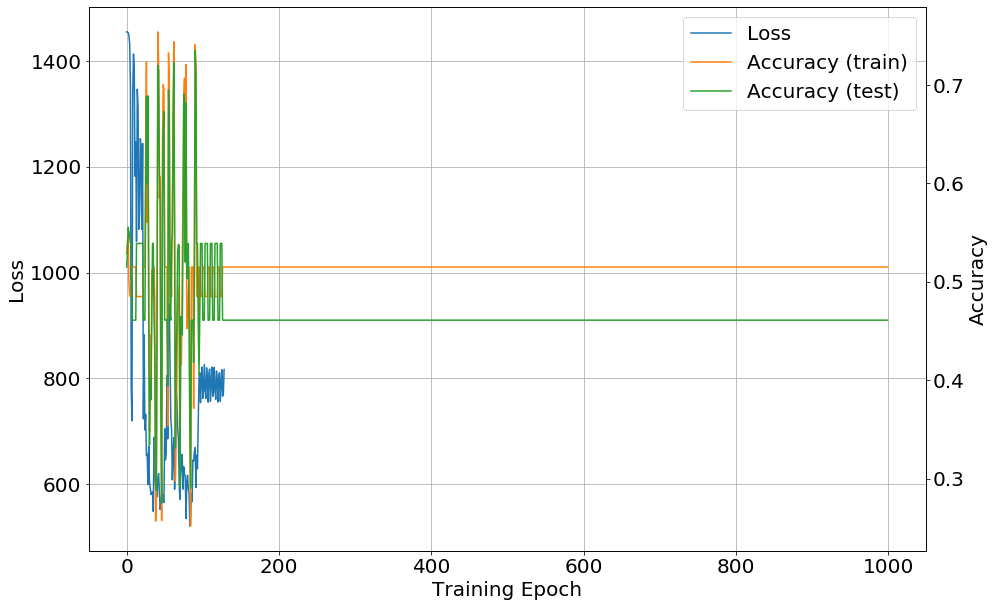

In [28]:
momentum = 0.0
accuracyMomentumTrain = []
accuracyMomentumTest = []
computationTimeMomentum = []
momentumNum = []

for ii in np.arange(0,11):
    momentumNum.append(momentum)
    print('Iteration: {}'.format(ii))
    print('Momemtum = {}'.format(momentum))
    modelTemp = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, momentum, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
    modelTemp.fit(trainX, trainY, validX, validY, 1000, 100)
    accuracyMomentumTest.append(modelTemp.finalAccuraciesTest)
    accuracyMomentumTrain.append(modelTemp.finalAccuraciesTrain)
    computationTimeMomentum.append(modelTemp.compTime)
    momentum = momentum + 0.1

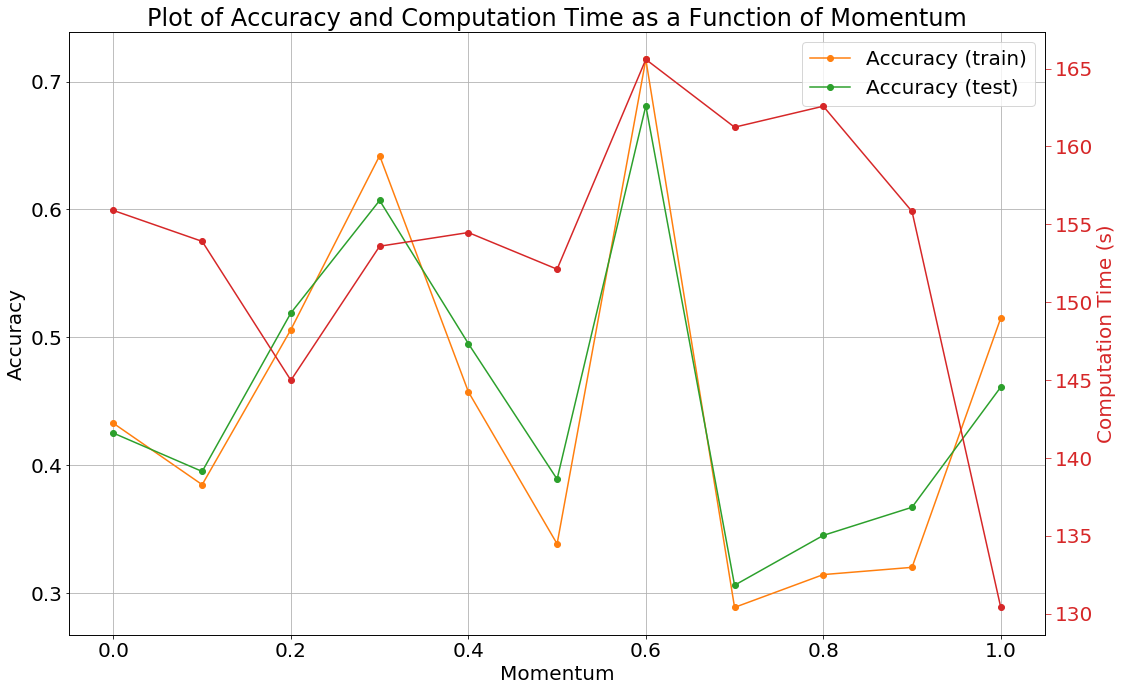

In [29]:
# Plot of accuracy as a function of momentum
fig, ax1 = plt.subplots(figsize=(16,10))
ax1.set_xlabel('Momentum')
ax1.set_ylabel('Accuracy')
ax1.plot(momentumNum, accuracyMomentumTrain, marker='o', markersize=6, color='tab:orange', label='Accuracy (train)')
ax1.plot(momentumNum, accuracyMomentumTest, marker='o', markersize=6, color='tab:green', label='Accuracy (test)')
ax1.xaxis.grid('both')
ax1.yaxis.grid('both')
ax1.set_title('Plot of Accuracy and Computation Time as a Function of Momentum')
ax1.legend()

ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Computation Time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(momentumNum, computationTimeMomentum, color=color, marker='o', label='Computation time')
ax2.tick_params(which='both',axis='y',length=6, color=color,labelcolor=color)
fig.tight_layout()

### Discussion
From the plot above, we can see that the although the computation time reached a maximum, both accuracies also reached a maximum. Testing accuracy reached a maximum at a momentum of $\gamma=0.6$. Perhaps altering the regularization parameters can also help. Let's try a few different values of $\lambda_{1}$ and $\lambda_{2}$.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 100, loss = 815.428989, training accuracy = 0.443333, test accuracy = 0.450000
[INFO] epoch = 200, loss = 795.099720, training accuracy = 0.396667, test accuracy = 0.410000
[INFO] epoch = 300, loss = 754.561050, training accuracy = 0.321667, test accuracy = 0.345000
[INFO] epoch = 400, loss = 670.278273, training accuracy = 0.283333, test accuracy = 0.335000
[INFO] epoch = 500, loss = 624.722371, training accuracy = 0.295000, test accuracy = 0.355000
[INFO] epoch = 600, loss = 612.841530, training accuracy = 0.288333, test accuracy = 0.335000
[INFO] epoch = 700, loss = 602.198904, training accuracy = 0.320000, test accuracy = 0.360000
[INFO] epoch = 800, loss = 590.927258, training accuracy = 0.335000, test accuracy = 0.365000
[INFO] epoch = 900, loss = 588.302208, training accuracy = 0.338333, test accuracy = 0.370000
[INFO] epoch = 1000, loss = 571.968867, training accuracy = 0.346667, test accuracy = 0.365000
[INFO] Total computation time: 30.522


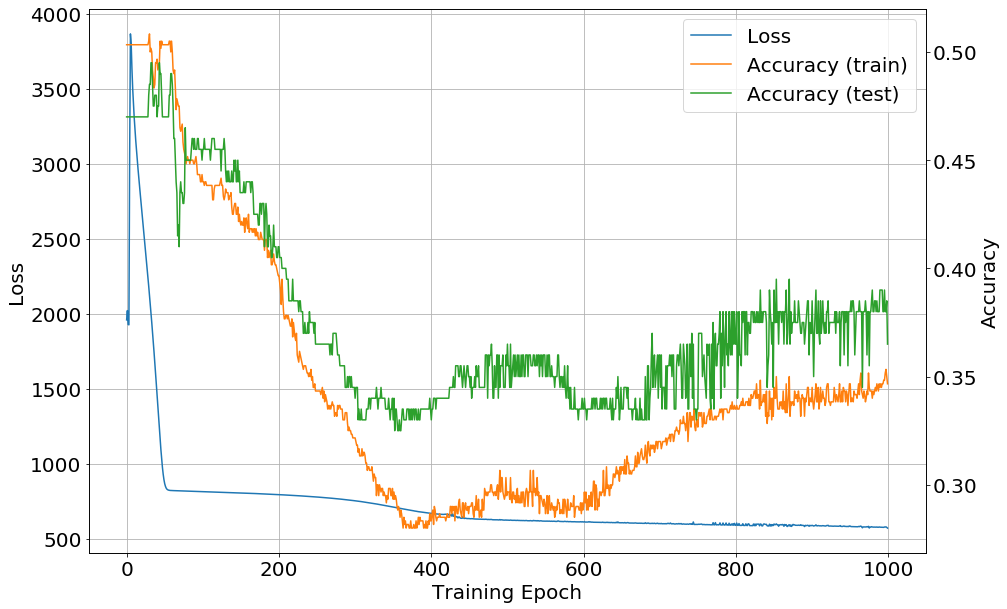

In [38]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 0.5, 0.1, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 100, loss = 817.920470, training accuracy = 0.468333, test accuracy = 0.510000
[INFO] epoch = 200, loss = 800.677079, training accuracy = 0.413333, test accuracy = 0.415000
[INFO] epoch = 300, loss = 770.102903, training accuracy = 0.411667, test accuracy = 0.420000
[INFO] epoch = 400, loss = 695.254597, training accuracy = 0.383333, test accuracy = 0.395000
[INFO] epoch = 500, loss = 630.821129, training accuracy = 0.355000, test accuracy = 0.375000
[INFO] epoch = 600, loss = 615.311587, training accuracy = 0.346667, test accuracy = 0.375000
[INFO] epoch = 700, loss = 604.688937, training accuracy = 0.336667, test accuracy = 0.390000
[INFO] epoch = 800, loss = 593.526661, training accuracy = 0.345000, test accuracy = 0.405000
[INFO] epoch = 900, loss = 592.696644, training accuracy = 0.343333, test accuracy = 0.385000
[INFO] epoch = 1000, loss = 579.012737, training accuracy = 0.340000, test accuracy = 0.355000
[INFO] Total computation time: 29.718


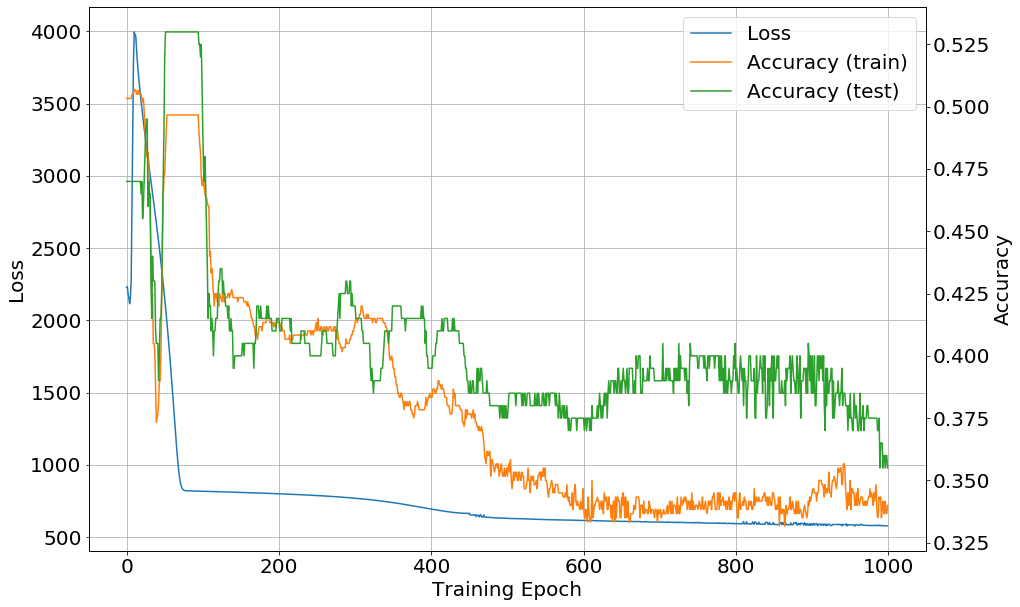

In [39]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 0.5, 0.5, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 100, loss = 814.836015, training accuracy = 0.428333, test accuracy = 0.475000
[INFO] epoch = 200, loss = 793.032524, training accuracy = 0.470000, test accuracy = 0.450000
[INFO] epoch = 300, loss = 748.125890, training accuracy = 0.475000, test accuracy = 0.425000
[INFO] epoch = 400, loss = 665.159008, training accuracy = 0.545000, test accuracy = 0.515000
[INFO] epoch = 500, loss = 623.444527, training accuracy = 0.646667, test accuracy = 0.620000
[INFO] epoch = 600, loss = 610.981969, training accuracy = 0.680000, test accuracy = 0.625000
[INFO] epoch = 700, loss = 598.377696, training accuracy = 0.675000, test accuracy = 0.610000
[INFO] epoch = 800, loss = 588.697878, training accuracy = 0.673333, test accuracy = 0.615000
[INFO] epoch = 900, loss = 577.563093, training accuracy = 0.676667, test accuracy = 0.610000
[INFO] epoch = 1000, loss = 571.210159, training accuracy = 0.670000, test accuracy = 0.620000
[INFO] Total computation time: 29.939


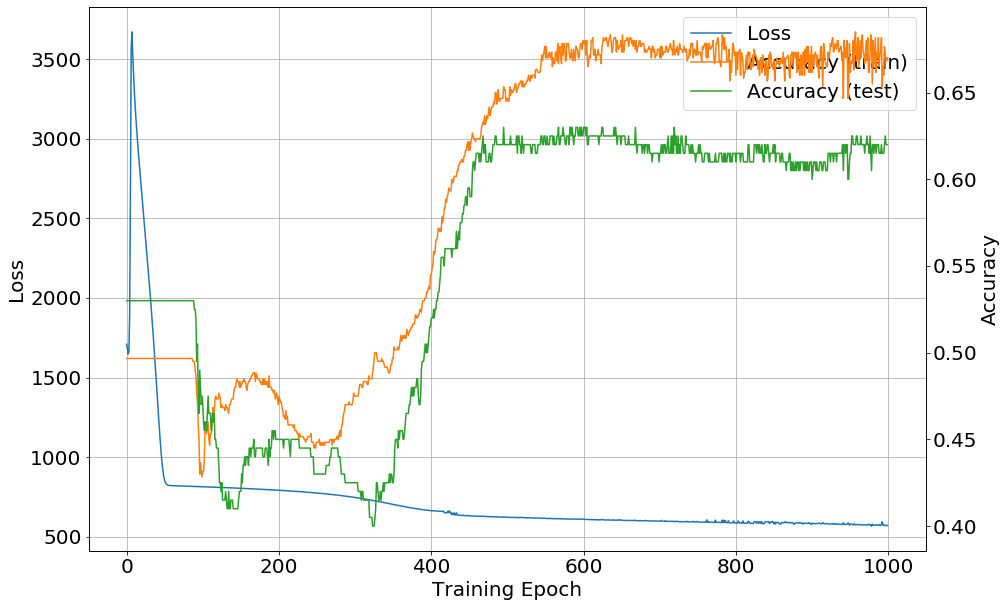

In [40]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 0.8, 0.5, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

[INFO] epoch = 100, loss = 817.061584, training accuracy = 0.446667, test accuracy = 0.420000
[INFO] epoch = 200, loss = 797.251567, training accuracy = 0.425000, test accuracy = 0.410000
[INFO] epoch = 300, loss = 759.379585, training accuracy = 0.531667, test accuracy = 0.525000


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 400, loss = 680.315681, training accuracy = 0.685000, test accuracy = 0.625000
[INFO] epoch = 500, loss = 630.270541, training accuracy = 0.721667, test accuracy = 0.645000
[INFO] epoch = 600, loss = 615.901943, training accuracy = 0.725000, test accuracy = 0.660000
[INFO] epoch = 700, loss = 603.986304, training accuracy = 0.723333, test accuracy = 0.660000
[INFO] epoch = 800, loss = 592.643998, training accuracy = 0.725000, test accuracy = 0.685000
[INFO] epoch = 900, loss = 591.536543, training accuracy = 0.711667, test accuracy = 0.675000
[INFO] epoch = 1000, loss = 577.678307, training accuracy = 0.710000, test accuracy = 0.665000
[INFO] Total computation time: 28.799


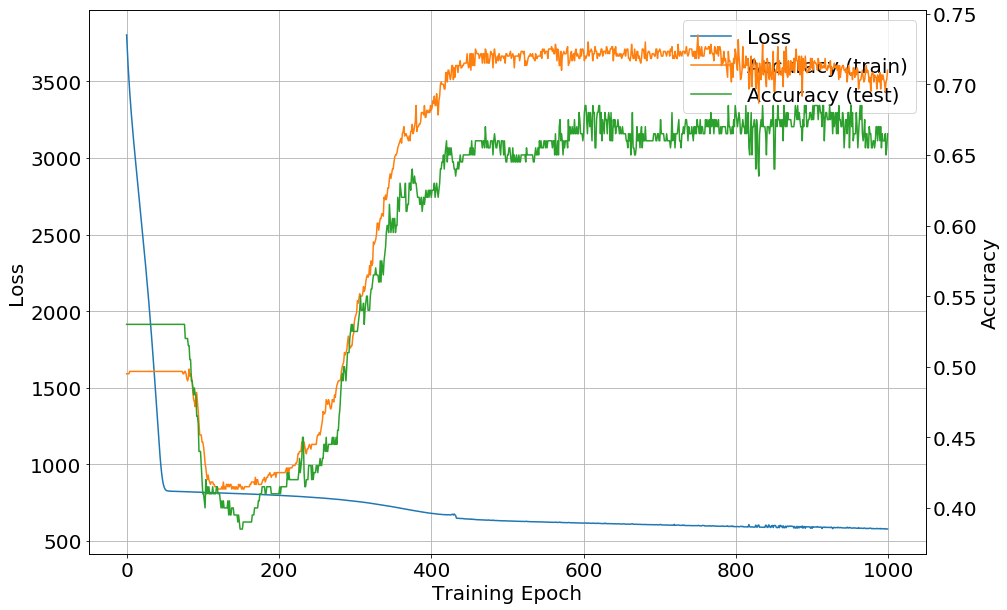

In [41]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 0.8, 0.8, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 100, loss = 819.052002, training accuracy = 0.566667, test accuracy = 0.510000
[INFO] epoch = 200, loss = 800.169902, training accuracy = 0.560000, test accuracy = 0.570000
[INFO] epoch = 300, loss = 766.993083, training accuracy = 0.588333, test accuracy = 0.585000
[INFO] epoch = 400, loss = 688.888162, training accuracy = 0.673333, test accuracy = 0.670000
[INFO] epoch = 500, loss = 628.829588, training accuracy = 0.625000, test accuracy = 0.630000
[INFO] epoch = 600, loss = 614.238711, training accuracy = 0.630000, test accuracy = 0.630000
[INFO] epoch = 700, loss = 602.520587, training accuracy = 0.623333, test accuracy = 0.650000
[INFO] epoch = 800, loss = 594.237109, training accuracy = 0.605000, test accuracy = 0.640000
[INFO] epoch = 900, loss = 589.218917, training accuracy = 0.600000, test accuracy = 0.600000
[INFO] epoch = 1000, loss = 582.532181, training accuracy = 0.600000, test accuracy = 0.655000
[INFO] Total computation time: 28.454


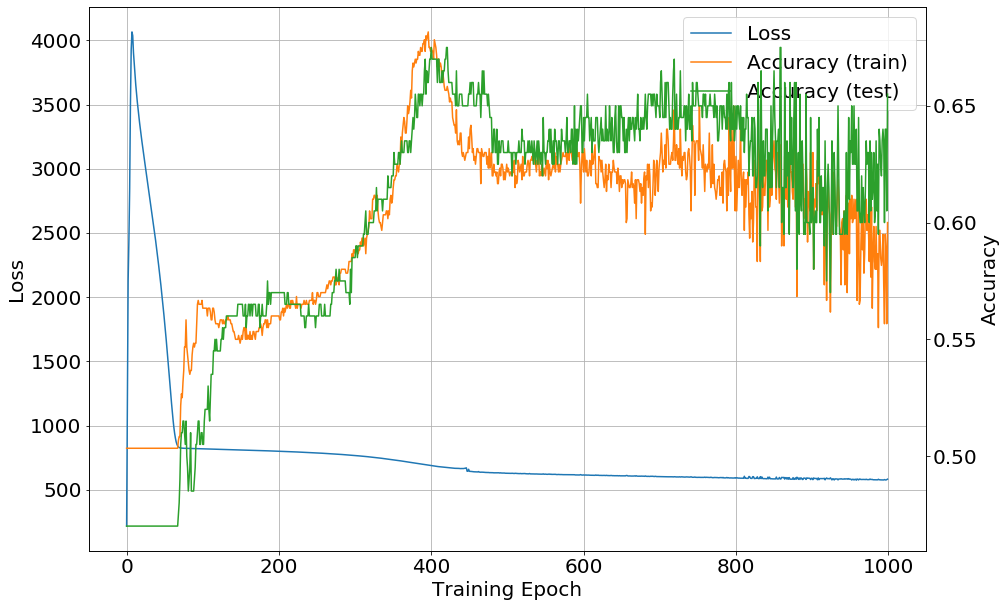

In [42]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 0.5, 0.8, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 100, loss = 838.192051, training accuracy = 0.393333, test accuracy = 0.415000
[INFO] epoch = 200, loss = 820.593392, training accuracy = 0.375000, test accuracy = 0.350000
[INFO] epoch = 300, loss = 795.122596, training accuracy = 0.343333, test accuracy = 0.355000
[INFO] epoch = 400, loss = 740.186319, training accuracy = 0.288333, test accuracy = 0.315000
[INFO] epoch = 500, loss = 678.602952, training accuracy = 0.253333, test accuracy = 0.320000
[INFO] epoch = 600, loss = 638.305512, training accuracy = 0.266667, test accuracy = 0.315000
[INFO] epoch = 700, loss = 626.857263, training accuracy = 0.321667, test accuracy = 0.300000
[INFO] epoch = 800, loss = 618.554552, training accuracy = 0.400000, test accuracy = 0.430000
[INFO] epoch = 900, loss = 610.706160, training accuracy = 0.413333, test accuracy = 0.430000
[INFO] epoch = 1000, loss = 601.774970, training accuracy = 0.423333, test accuracy = 0.465000
[INFO] Total computation time: 29.004


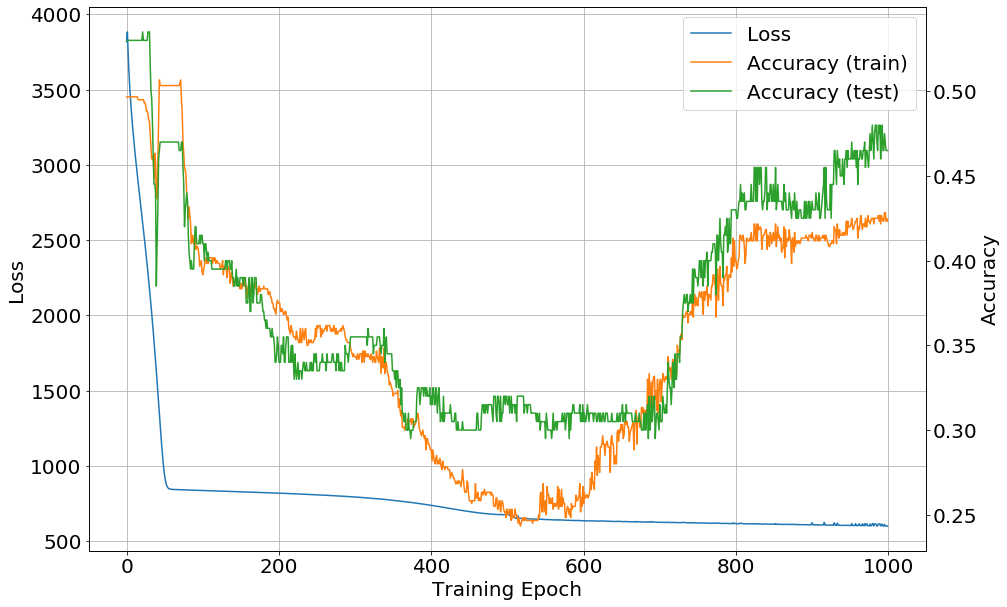

In [43]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 5, 5, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

### Discussion
Since altering the regularization penalties didn't help much, let's try different activation functions.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 100, loss = 818.953210, training accuracy = 0.501667, test accuracy = 0.535000
[INFO] epoch = 200, loss = 800.839481, training accuracy = 0.556667, test accuracy = 0.605000
[INFO] epoch = 300, loss = 769.960826, training accuracy = 0.585000, test accuracy = 0.640000
[INFO] epoch = 400, loss = 696.414854, training accuracy = 0.668333, test accuracy = 0.630000
[INFO] epoch = 500, loss = 631.409235, training accuracy = 0.685000, test accuracy = 0.640000
[INFO] epoch = 600, loss = 617.262402, training accuracy = 0.683333, test accuracy = 0.655000
[INFO] epoch = 700, loss = 606.707213, training accuracy = 0.675000, test accuracy = 0.670000
[INFO] epoch = 800, loss = 595.864005, training accuracy = 0.678333, test accuracy = 0.680000
[INFO] epoch = 900, loss = 584.719249, training accuracy = 0.695000, test accuracy = 0.700000
[INFO] epoch = 1000, loss = 581.919498, training accuracy = 0.698333, test accuracy = 0.705000
[INFO] Total computation time: 29.370


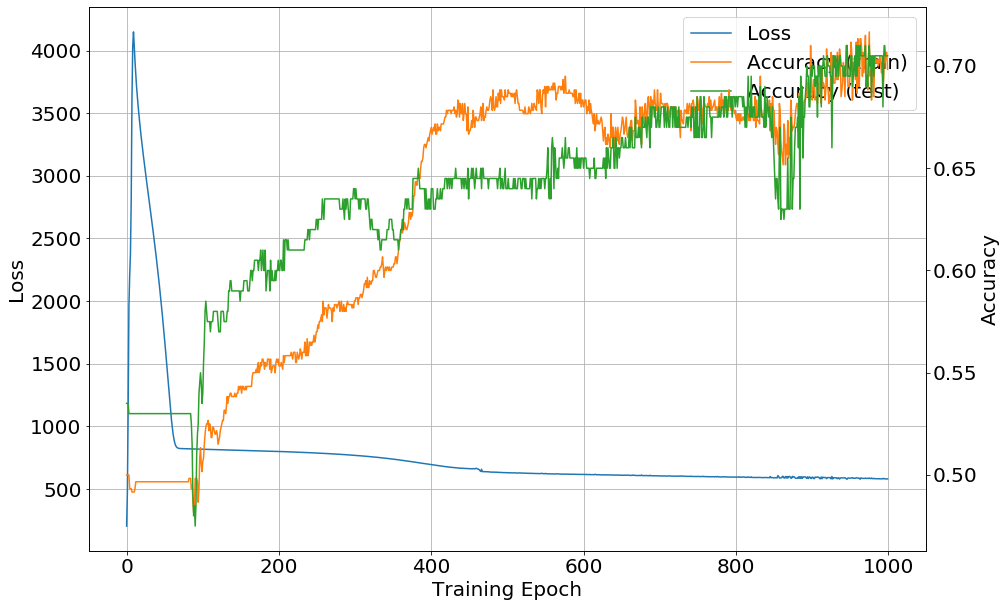

In [33]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 0.1, 0.1, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

[INFO] epoch = 100, loss = 825.505779, training accuracy = 0.498333, test accuracy = 0.460000
[INFO] epoch = 200, loss = 808.834750, training accuracy = 0.526667, test accuracy = 0.475000
[INFO] epoch = 300, loss = 784.615259, training accuracy = 0.523333, test accuracy = 0.520000
[INFO] epoch = 400, loss = 728.672798, training accuracy = 0.545000, test accuracy = 0.490000


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 500, loss = 643.302430, training accuracy = 0.606667, test accuracy = 0.610000
[INFO] epoch = 600, loss = 622.814021, training accuracy = 0.615000, test accuracy = 0.585000
[INFO] epoch = 700, loss = 611.143865, training accuracy = 0.581667, test accuracy = 0.585000
[INFO] epoch = 800, loss = 600.584323, training accuracy = 0.581667, test accuracy = 0.575000
[INFO] epoch = 900, loss = 591.294958, training accuracy = 0.628333, test accuracy = 0.600000
[INFO] epoch = 1000, loss = 589.071694, training accuracy = 0.641667, test accuracy = 0.625000
[INFO] Total computation time: 23.996


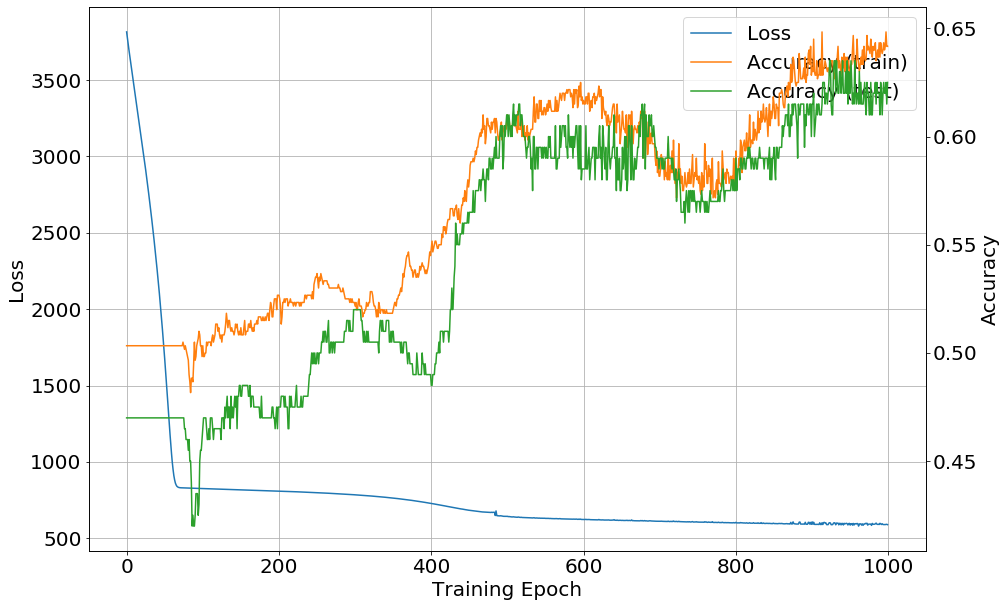

In [34]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 0.1, 0.1, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ReLU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

### Discussion
Given the trend (and also the computation time), let's try increasing the number of epochs to see  how much the accuracy can improve.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 1000, loss = 568.580704, training accuracy = 0.251667, test accuracy = 0.285000
[INFO] epoch = 2000, loss = 471.404930, training accuracy = 0.248333, test accuracy = 0.280000
[INFO] epoch = 3000, loss = 373.777627, training accuracy = 0.328333, test accuracy = 0.330000
[INFO] epoch = 4000, loss = 277.430773, training accuracy = 0.423333, test accuracy = 0.390000
[INFO] epoch = 5000, loss = 197.098456, training accuracy = 0.478333, test accuracy = 0.415000
[INFO] epoch = 6000, loss = 133.685768, training accuracy = 0.450000, test accuracy = 0.405000
[INFO] epoch = 7000, loss = 96.954120, training accuracy = 0.555000, test accuracy = 0.415000
[INFO] epoch = 8000, loss = 72.066722, training accuracy = 0.635000, test accuracy = 0.455000
[INFO] epoch = 9000, loss = 55.784061, training accuracy = 0.666667, test accuracy = 0.465000
[INFO] epoch = 10000, loss = 44.393489, training accuracy = 0.650000, test accuracy = 0.480000
[INFO] Total computation time: 227.564


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:2485: RuntimeWarning: overflow encountered in double_scalars
  x1t += delta


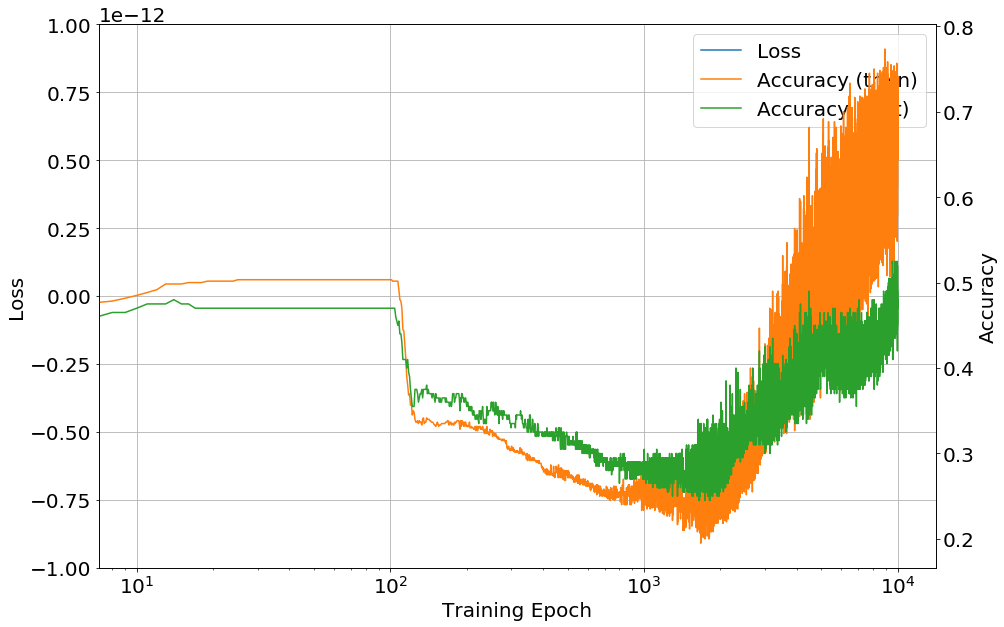

In [45]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 0.1, 0.1, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ReLU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 10000, 1000)

[INFO] epoch = 100, loss = 832.169968, training accuracy = 0.588333, test accuracy = 0.575000
[INFO] epoch = 200, loss = 832.166464, training accuracy = 0.598333, test accuracy = 0.590000
[INFO] epoch = 300, loss = 832.174313, training accuracy = 0.590000, test accuracy = 0.590000
[INFO] epoch = 400, loss = 832.166427, training accuracy = 0.581667, test accuracy = 0.565000
[INFO] epoch = 500, loss = 832.164154, training accuracy = 0.591667, test accuracy = 0.585000
[INFO] epoch = 600, loss = 832.163523, training accuracy = 0.596667, test accuracy = 0.585000
[INFO] epoch = 700, loss = 832.168736, training accuracy = 0.590000, test accuracy = 0.590000
[INFO] epoch = 800, loss = 832.162756, training accuracy = 0.598333, test accuracy = 0.590000
[INFO] epoch = 900, loss = 832.162339, training accuracy = 0.588333, test accuracy = 0.590000
[INFO] epoch = 1000, loss = 832.166964, training accuracy = 0.588333, test accuracy = 0.585000
[INFO] Total computation time: 27.427


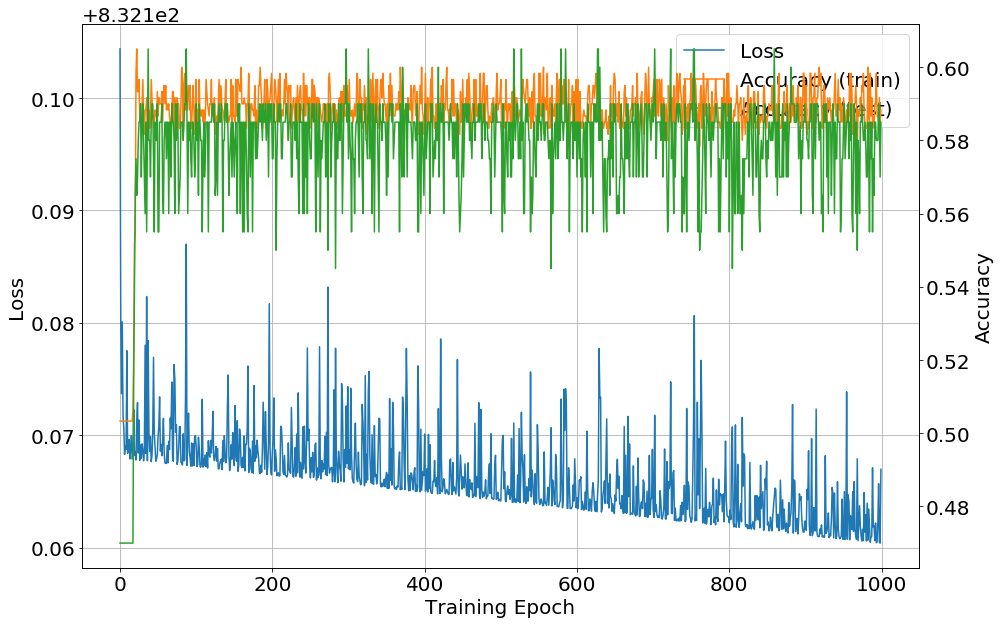

In [37]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.0001, 0.1, 0.1, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'sigmoid', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

### Discussion
From these results, it seems that the ELU activation function performs the best so far. Let's now try changing the batch size.

[INFO] epoch = 100, loss = 297.800038, training accuracy = 0.496667, test accuracy = 0.530000
[INFO] epoch = 200, loss = 297.339014, training accuracy = 0.496667, test accuracy = 0.530000
[INFO] epoch = 300, loss = 296.743773, training accuracy = 0.496667, test accuracy = 0.530000
[INFO] epoch = 400, loss = 295.867398, training accuracy = 0.496667, test accuracy = 0.530000
[INFO] epoch = 500, loss = 294.454892, training accuracy = 0.496667, test accuracy = 0.530000
[INFO] epoch = 600, loss = 291.967799, training accuracy = 0.496667, test accuracy = 0.530000
[INFO] epoch = 700, loss = 287.090217, training accuracy = 0.496667, test accuracy = 0.530000
[INFO] epoch = 800, loss = 276.411932, training accuracy = 0.496667, test accuracy = 0.530000
[INFO] epoch = 900, loss = 253.033182, training accuracy = 0.496667, test accuracy = 0.530000
[INFO] epoch = 1000, loss = 178.489830, training accuracy = 0.496667, test accuracy = 0.530000
[INFO] Total computation time: 21.912


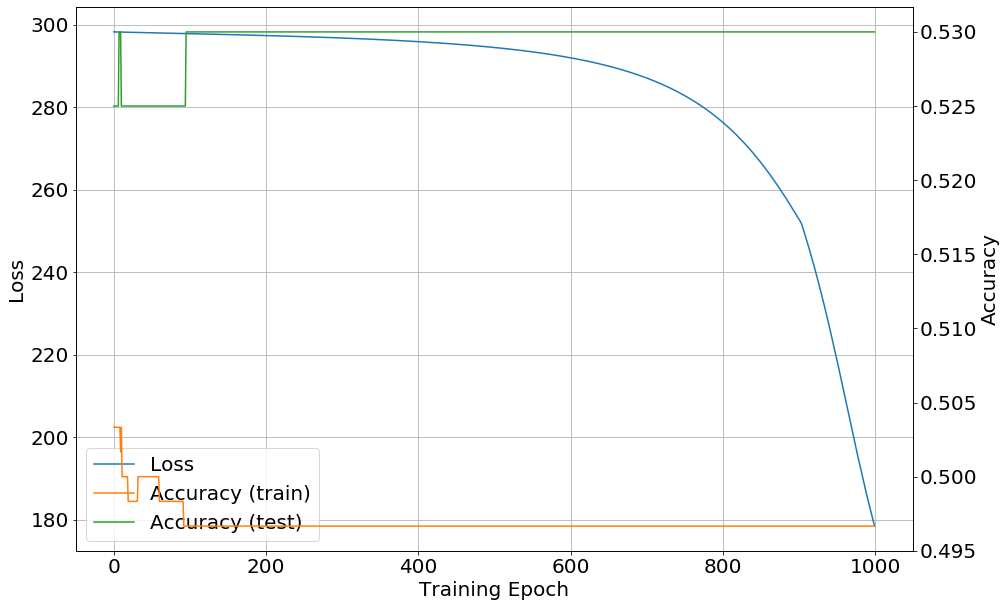

In [46]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 64, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'sum-of-squares')
model.fit(trainX, trainY, validX, validY, 1000, 100)

### Discussion
That clearly had a detrimental effect to the performance. Let's try training with the best parameters again and see if we can reproduce previous results.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 1000, loss = 830.987115, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] epoch = 2000, loss = 814.133694, training accuracy = 0.501667, test accuracy = 0.500000
[INFO] epoch = 3000, loss = 793.039060, training accuracy = 0.465000, test accuracy = 0.470000
[INFO] epoch = 4000, loss = 750.239273, training accuracy = 0.455000, test accuracy = 0.420000
[INFO] epoch = 5000, loss = 671.707552, training accuracy = 0.616667, test accuracy = 0.580000
[INFO] epoch = 6000, loss = 628.194471, training accuracy = 0.700000, test accuracy = 0.680000
[INFO] epoch = 7000, loss = 613.851102, training accuracy = 0.720000, test accuracy = 0.695000
[INFO] epoch = 8000, loss = 600.493795, training accuracy = 0.730000, test accuracy = 0.720000
[INFO] epoch = 9000, loss = 600.586972, training accuracy = 0.735000, test accuracy = 0.725000
[INFO] epoch = 10000, loss = 581.751002, training accuracy = 0.736667, test accuracy = 0.730000
[INFO] Total computation time: 305.381


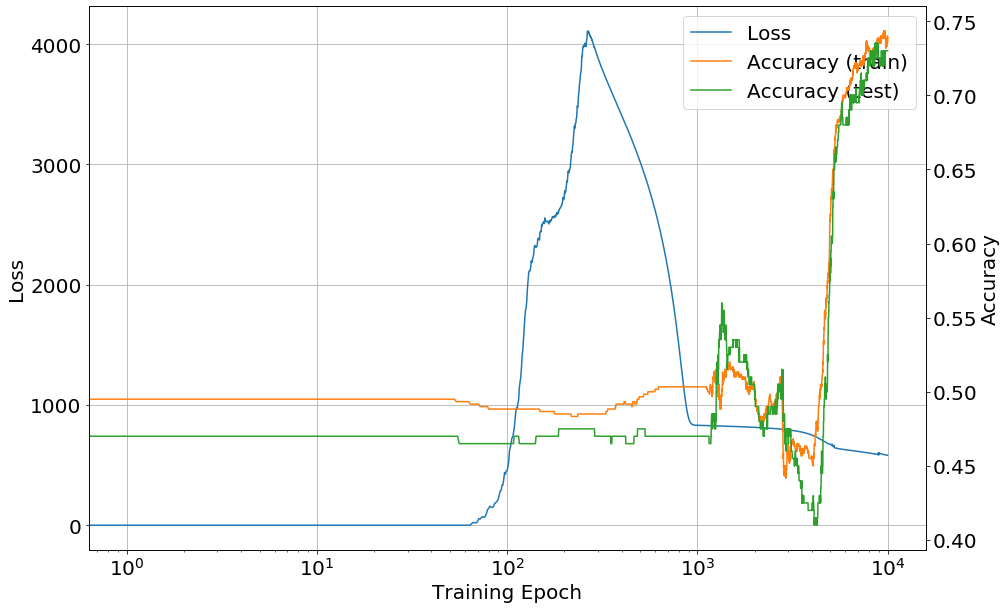

In [51]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 10000, 1000)

### Discussion
The last run achieved the best accuracy so far, with $10^{4}$ epochs. Let's now try some weight initialization strategies to see if we can improve further.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 1000, loss = 13036.504276, training accuracy = 0.508333, test accuracy = 0.470000
[INFO] epoch = 2000, loss = 13330.632940, training accuracy = 0.508333, test accuracy = 0.470000


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: divide by zero encountered in log


[INFO] epoch = 3000, loss = 13380.826723, training accuracy = 0.510000, test accuracy = 0.470000
[INFO] epoch = 4000, loss = 13501.850478, training accuracy = 0.508333, test accuracy = 0.470000


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in multiply


[INFO] epoch = 5000, loss = 13741.655561, training accuracy = 0.510000, test accuracy = 0.470000
[INFO] epoch = 6000, loss = 13797.527321, training accuracy = 0.508333, test accuracy = 0.470000
[INFO] epoch = 7000, loss = 14118.572853, training accuracy = 0.506667, test accuracy = 0.470000
[INFO] epoch = 8000, loss = 14383.808909, training accuracy = 0.506667, test accuracy = 0.470000
[INFO] epoch = 9000, loss = 14278.183756, training accuracy = 0.505000, test accuracy = 0.470000
[INFO] epoch = 10000, loss = 13777.943650, training accuracy = 0.505000, test accuracy = 0.470000
[INFO] Total computation time: 314.432


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:2485: RuntimeWarning: overflow encountered in double_scalars
  x1t += delta


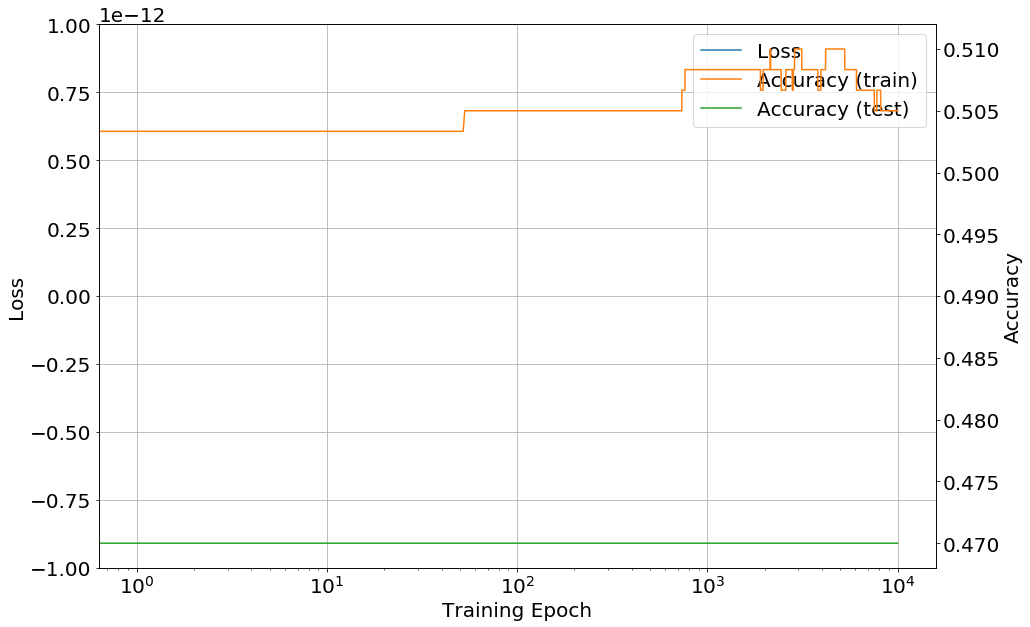

In [52]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.6, initialization = ['normal', 1000], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 10000, 1000)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 1000, loss = 4616.535947, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] epoch = 2000, loss = 8046.635229, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] epoch = 3000, loss = 7995.524035, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] epoch = 4000, loss = 7805.591504, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] epoch = 5000, loss = 7657.168896, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] epoch = 6000, loss = 7535.505151, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] epoch = 7000, loss = 7429.275527, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] epoch = 8000, loss = 7330.911132, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] epoch = 9000, loss = 7234.620420, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] epoch = 10000, loss = 7137.627624, training accuracy = 0.503333, test accuracy = 0.470000
[INFO] Total computation time: 317.412


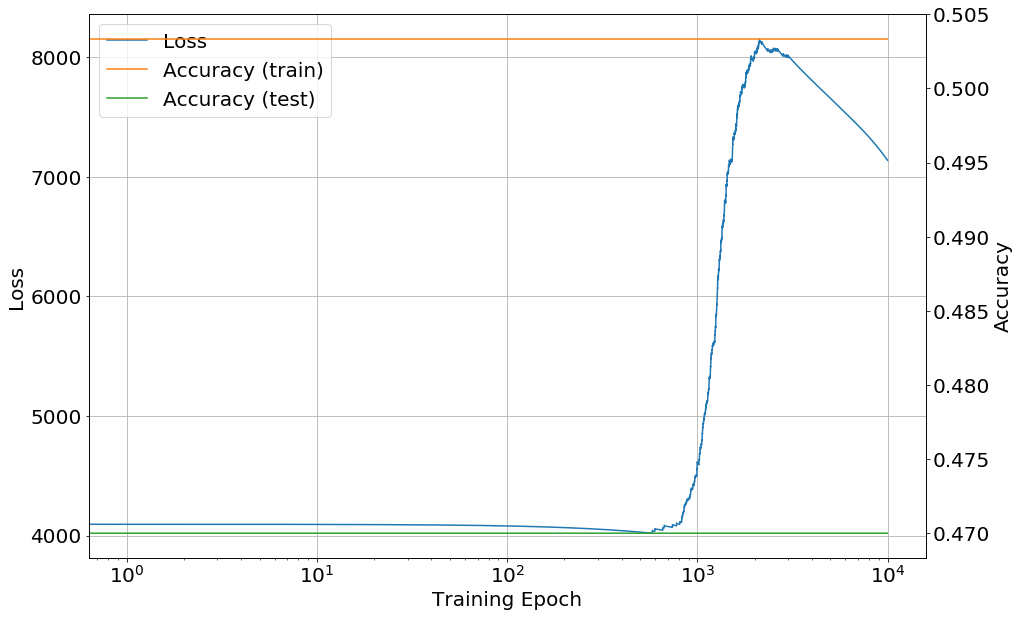

In [53]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.6, initialization = ['normal', 100], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 10000, 1000)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 100, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 200, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 300, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 400, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 500, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 600, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 700, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 800, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 900, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 1000, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] Total computation time: 12.128


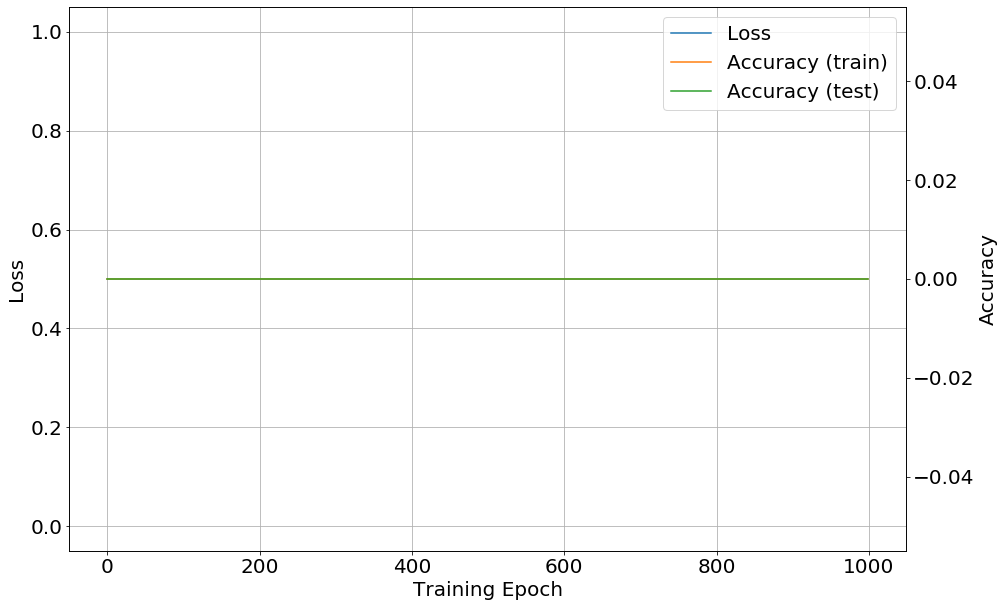

In [57]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.6, initialization = 'Glorot', activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 100, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 200, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 300, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 400, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 500, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 600, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 700, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 800, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 900, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 1000, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] Total computation time: 11.521


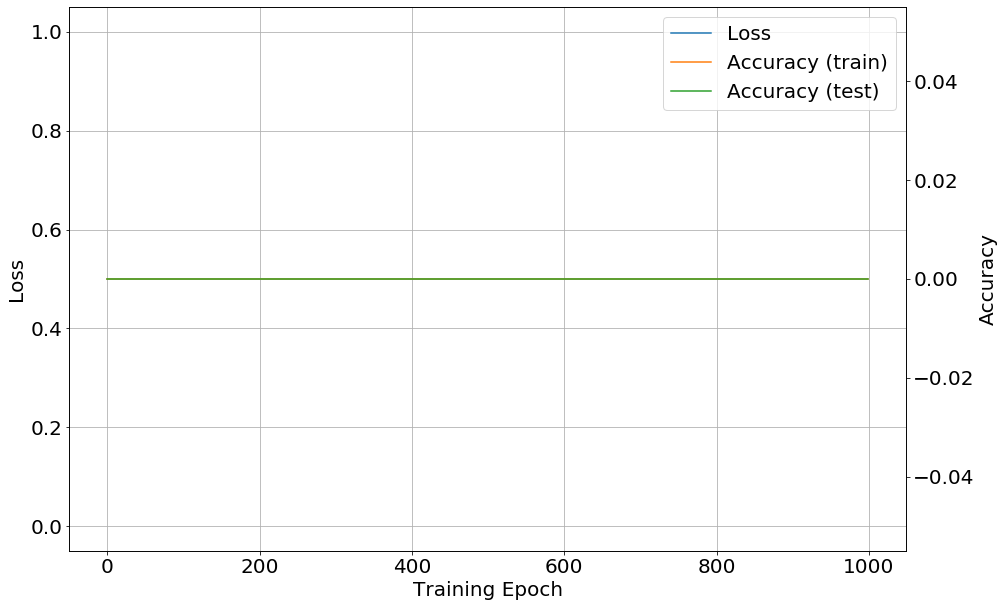

In [58]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.6, initialization = 'He', activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 100, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 200, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 300, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 400, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 500, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 600, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 700, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 800, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 900, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] epoch = 1000, loss = inf, training accuracy = 0.000000, test accuracy = 0.000000
[INFO] Total computation time: 78.998


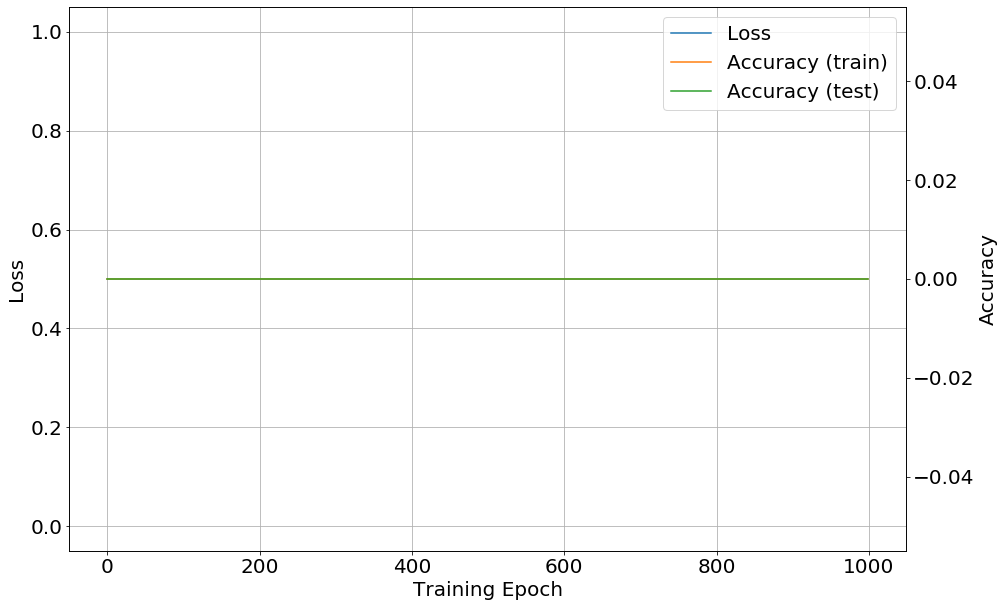

In [14]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.6, initialization = 'LeCun', activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 1000, 100)

### Discussion
Since these weight initialization strategies didn't work, let's try differnt options for scaling the data. Recall that all of the results above were generated using data scaled to the maximum energy value of the jet, so each pixel value was in the range $[0,1]$. As noted in homework 4, there are several functions in the `sklearn` module that can be used. For reference, we will try training the data without scaling, then using `sklearn`'s `StandardScaler` and `QuantileTransformer` which showed promising results when applied to the CIFAR-10 dataset.

#### Without Scaling the Data
For our baseline run, we need to load the data again since the current input data is scaled. 

In [16]:
# Splitting the data
numIm  = 5000  # Number of images to train/validate
inputs = 25*25 # pixels (input nodes) 

halfNumIm = int(numIm / 2) # Half of data for QCD, half for W

jetIndRandW   = np.random.choice(W[0][:],halfNumIm)   # Return values (indices) of randomly selected image numbers
jetIndRandQCD = np.random.choice(QCD[0][:],halfNumIm) # Return values (indices) of randomly selected image numbers

JetDataW     = np.take(jetIm, jetIndRandW, axis=0)
JetDataQCD   = np.take(jetIm, jetIndRandQCD, axis=0)
labelIndices = np.concatenate((jetIndRandW, jetIndRandQCD))
JetLInput    = np.take(jetLabels, labelIndices)

# Confirm dimensions
print('Shape of W data: {}'.format(JetDataW.shape))
print('Shape of QCD data: {}'.format(JetDataQCD.shape))
print('Shape of input label data: {}'.format(JetLInput.shape))

# Concatenate W and QCD image arrays
X = np.concatenate((JetDataW, JetDataQCD), axis=0) 
X = X.reshape([numIm, inputs]) # Reshape to match input nodes
print('Shape of input data {}'.format(X.shape)) 

# First split the data into 80/20
(tempX, testX, tempY, testY) = train_test_split(X, JetLInput, test_size = 0.20, random_state = 1) # Set seed to 1 for reproducibility

# Split 80% testing into 60% (75% of 80) training, 20% validation (25% of 80)
(trainX, validX, trainY, validY) = train_test_split(tempX, tempY, test_size = 0.25, random_state = 1)

Shape of W data: (2500, 25, 25)
Shape of QCD data: (2500, 25, 25)
Shape of input label data: (5000,)
Shape of input data (5000, 625)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 1000, loss = 1699.408432, training accuracy = 0.496333, test accuracy = 0.475000
[INFO] epoch = 2000, loss = 912.684456, training accuracy = 0.462000, test accuracy = 0.475000
[INFO] epoch = 3000, loss = 552.673191, training accuracy = 0.454000, test accuracy = 0.459000
[INFO] epoch = 4000, loss = 364.482176, training accuracy = 0.473333, test accuracy = 0.458000
[INFO] epoch = 5000, loss = 236.075260, training accuracy = 0.488667, test accuracy = 0.476000
[INFO] epoch = 6000, loss = 172.589431, training accuracy = 0.479333, test accuracy = 0.479000
[INFO] epoch = 7000, loss = 153.972987, training accuracy = 0.487667, test accuracy = 0.478000
[INFO] epoch = 8000, loss = 163.821076, training accuracy = 0.490000, test accuracy = 0.467000
[INFO] epoch = 9000, loss = 96.249279, training accuracy = 0.484667, test accuracy = 0.465000
[INFO] epoch = 10000, loss = 80.156865, training accuracy = 0.490333, test accuracy = 0.478000
[INFO] Total computation time: 1476.132


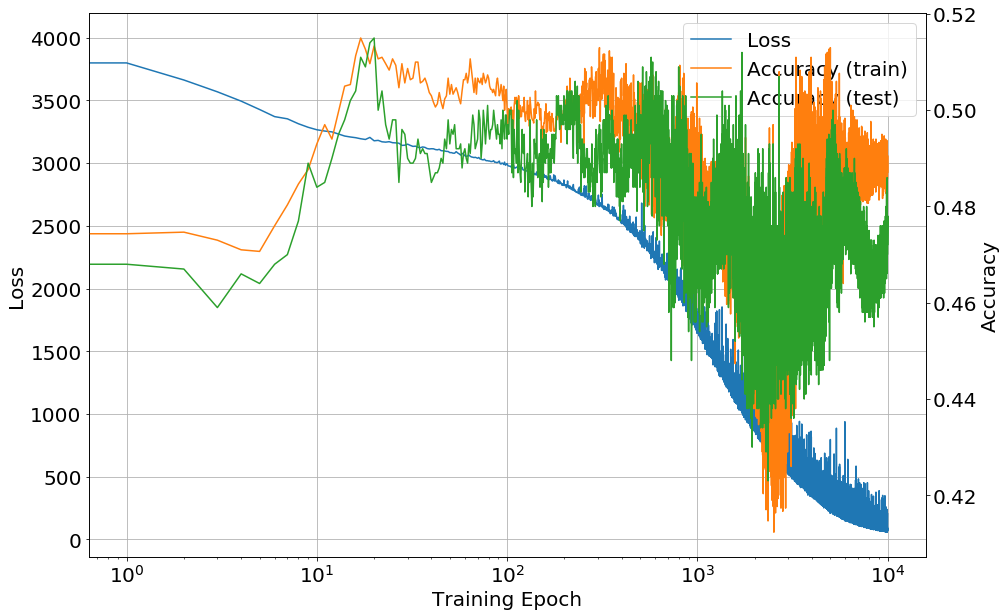

In [17]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 10000, 1000)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

In [18]:
# Scale the data to have a mean = 0 and standard deviation = 1
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

In [20]:
qt = QuantileTransformer()
transformedX = qt.fit_transform(X)

# First split the data into 80/20
(tempX, testX, tempY, testY) = train_test_split(transformedX, JetLInput, test_size = 0.20, random_state = 1) # Set seed to 1 for reproducibility

# Split 80% testing into 60% (75% of 80) training, 20% validation (25% of 80)
(trainX, validX, trainY, validY) = train_test_split(tempX, tempY, test_size = 0.25, random_state = 1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 1000, loss = 2090.357332, training accuracy = 0.539333, test accuracy = 0.542000
[INFO] epoch = 2000, loss = 319.064575, training accuracy = 0.546667, test accuracy = 0.527000
[INFO] epoch = 3000, loss = 69.354069, training accuracy = 0.521667, test accuracy = 0.514000
[INFO] epoch = 4000, loss = 20.856909, training accuracy = 0.502000, test accuracy = 0.505000
[INFO] epoch = 5000, loss = 13.640365, training accuracy = 0.476000, test accuracy = 0.491000
[INFO] epoch = 6000, loss = 11.855082, training accuracy = 0.474667, test accuracy = 0.490000
[INFO] epoch = 7000, loss = 11.536447, training accuracy = 0.486667, test accuracy = 0.495000
[INFO] epoch = 8000, loss = 10.614988, training accuracy = 0.497667, test accuracy = 0.508000
[INFO] epoch = 9000, loss = 10.659923, training accuracy = 0.504000, test accuracy = 0.523000
[INFO] epoch = 10000, loss = 10.267963, training accuracy = 0.505333, test accuracy = 0.524000
[INFO] Total computation time: 1472.325


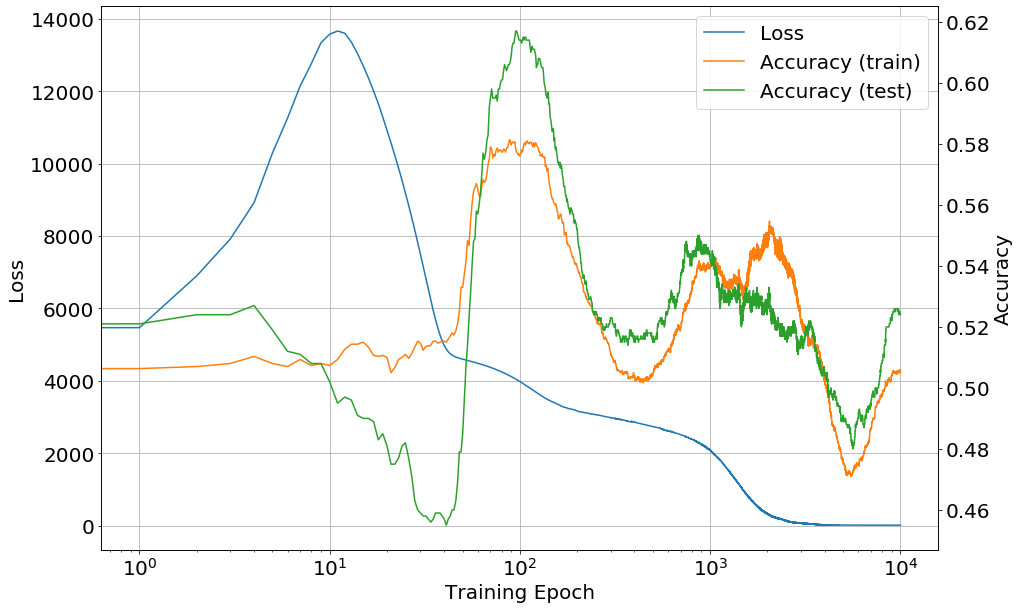

In [21]:
model = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
model.fit(trainX, trainY, validX, validY, 10000, 1000)

### Final Training and Testing of the Network
The tuning of the hyperparameters resulted in a best parameter list of
\begin{align*}
\alpha &= \times10^{-5}\\
\lambda_{1}&= \lambda_{2} =0.1\\
\gamma &= 0.6\\
\textrm{weight initialization} &= \textrm{'uniform', with } [-0.1,0.1]\\
\textrm{Activation function} &= \textrm{'ELU'}\\
\textrm{Loss function} &= \textrm{Cross Entropy}\\
\textrm{Architecture} &= [625,\, 64,\, 64,\,32,\, 2]\\
\textrm{Normalization/Scaling} &= \textrm{Data scaled to be in range } [0,1]
\end{align*}
with a validation accuracy of 73%. Using these parameters, we will split the full $8.73\times10^{5}$ image dataset into a 75/25 training test split. Presumably, the testing accuracy will be much higher since the full dataset will be used. Because of time constraints, we will train for 1000 epochs.

In [29]:
# Splitting the data
inputs = 25*25 # pixels (input nodes) 
numIm  = jetIm.shape[0]

X = jetIm.reshape([numIm, inputs])
y = jetLabels

print('Shape of input data {}'.format(X.shape)) 
print('Shape of label data {}'.format(y.shape)) 

# First split the data into 80/20
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1) # Set seed to 1 for reproducibility

Shape of input data (872666, 625)
Shape of label data (872666,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 100, loss = 527214.076388, training accuracy = 0.475524, test accuracy = 0.474898
[INFO] epoch = 200, loss = 515588.987075, training accuracy = 0.479142, test accuracy = 0.480815
[INFO] epoch = 300, loss = 507499.767268, training accuracy = 0.473286, test accuracy = 0.474141
[INFO] epoch = 400, loss = 503138.129972, training accuracy = 0.476147, test accuracy = 0.478665
[INFO] epoch = 500, loss = 505421.563692, training accuracy = 0.463750, test accuracy = 0.466528
[INFO] epoch = 600, loss = 497103.413341, training accuracy = 0.474995, test accuracy = 0.479023
[INFO] epoch = 700, loss = 493553.485517, training accuracy = 0.475833, test accuracy = 0.479720
[INFO] epoch = 800, loss = 485801.164688, training accuracy = 0.470080, test accuracy = 0.474348
[INFO] epoch = 900, loss = 478687.916787, training accuracy = 0.511634, test accuracy = 0.516132
[INFO] epoch = 1000, loss = 495108.714479, training accuracy = 0.519176, test accuracy = 0.521302
[INFO] Total computation time

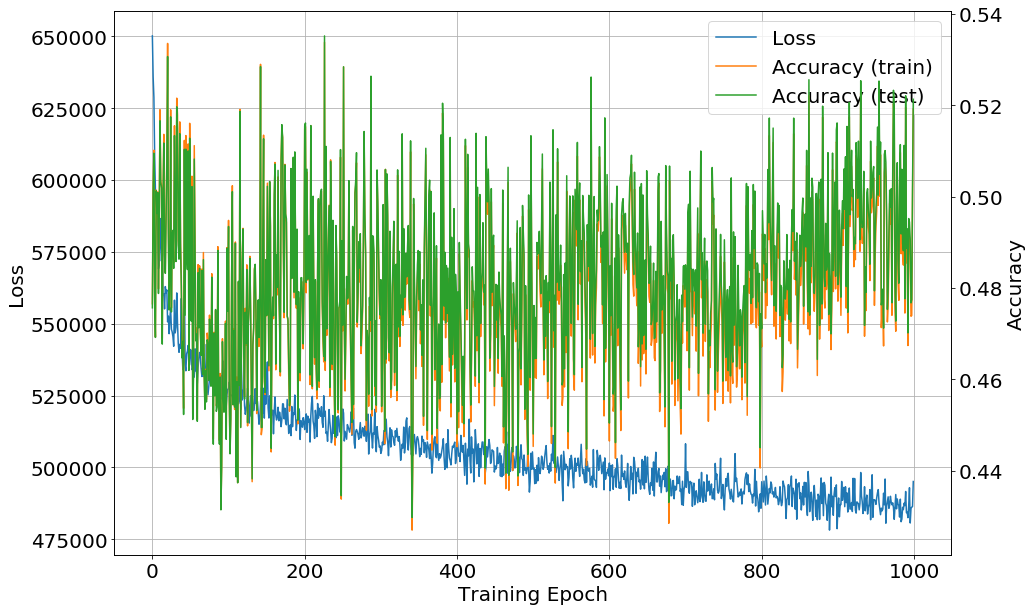

In [30]:
finalModel = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
finalModel.fit(trainX, trainY, testX, testY, 1000, 100)

In [34]:
# Splitting the data
inputs = 25*25 # pixels (input nodes) 
numIm  = jetIm.shape[0]

X = jetIm.reshape([numIm, inputs])
y = jetLabels

X = X / maxVal # Scale pixel values to [0,1]

print('Shape of input data {}'.format(X.shape)) 
print('Shape of label data {}'.format(y.shape)) 

# First split the data into 80/20
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1) # Set seed to 1 for reproducibility

Shape of input data (872666, 625)
Shape of label data (872666,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:334: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 674383.288933, training accuracy = 0.724534, test accuracy = 0.724601
[INFO] epoch = 20, loss = 648720.861910, training accuracy = 0.739025, test accuracy = 0.738705
[INFO] epoch = 30, loss = 635306.153519, training accuracy = 0.737352, test accuracy = 0.736427
[INFO] epoch = 40, loss = 634882.733561, training accuracy = 0.726673, test accuracy = 0.725582
[INFO] epoch = 50, loss = 625472.828719, training accuracy = 0.727266, test accuracy = 0.726402
[INFO] epoch = 60, loss = 613250.335113, training accuracy = 0.730169, test accuracy = 0.729570
[INFO] epoch = 70, loss = 612455.577379, training accuracy = 0.721601, test accuracy = 0.721163
[INFO] epoch = 80, loss = 601941.460482, training accuracy = 0.727230, test accuracy = 0.726842
[INFO] epoch = 90, loss = 596613.604643, training accuracy = 0.719611, test accuracy = 0.719046
[INFO] epoch = 100, loss = 586029.017132, training accuracy = 0.662768, test accuracy = 0.662658
[INFO] epoch = 110, loss = 590305.56860

[INFO] epoch = 860, loss = 508407.842481, training accuracy = 0.487836, test accuracy = 0.488236
[INFO] epoch = 870, loss = 509566.521443, training accuracy = 0.481011, test accuracy = 0.481796
[INFO] epoch = 880, loss = 515204.900059, training accuracy = 0.486028, test accuracy = 0.486389
[INFO] epoch = 890, loss = 512159.214223, training accuracy = 0.494224, test accuracy = 0.494259
[INFO] epoch = 900, loss = 516911.332451, training accuracy = 0.459145, test accuracy = 0.460418
[INFO] epoch = 910, loss = 518834.527789, training accuracy = 0.493373, test accuracy = 0.493287
[INFO] epoch = 920, loss = 513711.930829, training accuracy = 0.476804, test accuracy = 0.477295
[INFO] epoch = 930, loss = 508481.540693, training accuracy = 0.490231, test accuracy = 0.490624
[INFO] epoch = 940, loss = 510137.418645, training accuracy = 0.456303, test accuracy = 0.457109
[INFO] epoch = 950, loss = 512474.395277, training accuracy = 0.501568, test accuracy = 0.502308
[INFO] epoch = 960, loss = 509

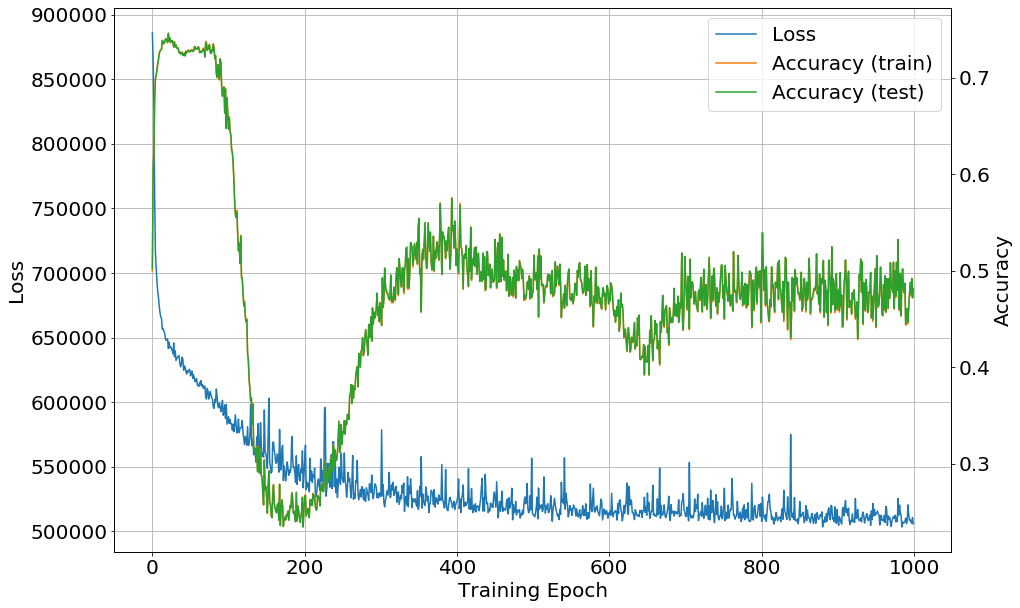

In [37]:
finalModel = FeedforwardNeuralNetwork([inputs, 64, 64, 32, 2], 0.00001, 0.1, 0.1, 32, 0.6, initialization = ['uniform', -0.1, 0.1], activations = 'ELU', loss= 'cross-entropy')
finalModel.fit(trainX, trainY, testX, testY, 1000, 10)

### Summary and Conclusions
We have seen that the best performance was obtained when tuning for hyperparameters using the following hyperparameters:
\begin{align*}
\alpha &= \times10^{-5}\\
\lambda_{1}&= \lambda_{2} =0.1\\
\gamma &= 0.6\\
\textrm{weight initialization} &= \textrm{'uniform', with } [-0.1,0.1]\\
\textrm{Activation function} &= \textrm{'ELU'}\\
\textrm{Loss function} &= \textrm{Cross Entropy}\\
\textrm{Architecture} &= [625,\, 64,\, 64,\,32,\, 2]\\
\textrm{Normalization/Scaling} &= \textrm{Data scaled to be in range } [0,1]
\end{align*}
The first run with the full dataset was accidentally run without first scaling the data. The final training and testing accuracies for this run were, repsectively, 51.9% and 52.3%. The model was run once more with the proper scaling of the input data, which resulted in a final testing accuracy of 49%. It is interesting to note that the testing accuracy was much lower than the highest achieved during the hyperparameter tuning (~73%). This is strange because I have never encountered a circumstance where training with the full dataset results in lower accuracy than when training with a subset of the dataset. It is also anomalous that the accuracies achieved a maximum at epoch 20 of 73.9%, and then decreased to ~47% at the 1000th epoch. 